In [1]:
import pandas as pd
# from LabData.DataLoaders.GutMBLoader import GutMBLoader
# from LabData.DataLoaders.SubjectLoader import SubjectLoader
# from LabData.DataLoaders.DietLoggingLoader import DietLoggingLoader
# from LabData.DataAnalyses.TenK_Trajectories.utils import get_diet_logging_around_stage
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from statistics import mean
from scipy import stats
import matplotlib.pyplot as plt
import pickle
import lightgbm as lgb
import os
import re
import seaborn as sns


In [166]:
SPECIES = 'segal_species' # 'mpa_species' or 'segal_species'
home_path = '/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/'
TARGETS = 'abundance' # 'abundance' or 'div'
PROBLEM = 'regression'
SUBSET = 'all' # 'all' or 'high_change_diet' or 'high_change_abundance' or 'low_change_diet' or 'low_change_abundance'

color1 = "#66C2A5"
single_style = "nature_single.mplstyle"
double_style = "nature_double.mplstyle"
third_style = "nature_third.mplstyle"
plt.rcParams["figure.dpi"] = 150
plt.style.use(single_style)

# Longitudinal Analysis
## Data Preparation

In [3]:
def read_results(df):
    output = []
    for col in df.columns:
        output.append(df[col])
    return tuple(output)

In [4]:
diet_mb = pd.read_pickle(f"/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/{SPECIES}/diet_mb.pkl")
with open(f'/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/{SPECIES}/my_lists.pkl', 'rb') as file:
    loaded_lists = pickle.load(file)
base_features, all_features, targets = loaded_lists
mb_names = pd.read_pickle(f"/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/mb_names.pkl")
diet_mb

,Acorn squash,Alfalfa sprouts,Almond Beverage,Almond flour,Almond spread,Almonds,Amba,Apple,Apple Cake,Apple Vinegar,...,fBin__94|gBin__449|sBin__656,fBin__95|gBin__450|sBin__659,fBin__96|gBin__457|sBin__669,fBin__97|gBin__462|sBin__676,fBin__97|gBin__462|sBin__678,fBin__99|gBin__469|sBin__687,Richness,Shannon_diversity,GMWI2_score,modified_HACK_top17_score
RegistrationCode,,,,,,,,,,,,,,,,,,,,,
10K_1000942861,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.016416,0.000000,0.0,...,-4.0,-4.0,-4.0,-4.000000,-4.000000,-4.00000,189,3.75,0.930216,96.28125
10K_1001201093,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.013895,0.000000,0.0,...,-4.0,-4.0,-4.0,-4.000000,-4.000000,-4.00000,150,3.34,0.881661,157.28125
10K_1002254441,0.0,0.0,0.0,0.0,0.0,0.081238,0.0,0.000000,0.000000,0.0,...,-4.0,-4.0,-4.0,-4.000000,-2.383721,-4.00000,250,4.25,0.820586,205.53125
10K_1003113258,0.0,0.0,0.0,0.0,0.0,0.002048,0.0,0.008929,0.000000,0.0,...,-4.0,-4.0,-4.0,-4.000000,-3.806766,-4.00000,262,4.29,1.025713,147.28125
10K_1007330152,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,-4.0,-4.0,-4.0,-4.000000,-1.937423,-2.98186,194,3.75,1.202788,92.56250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10K_9996884777,0.0,0.0,0.0,0.0,0.0,0.002401,0.0,0.000000,0.000000,0.0,...,-4.0,-4.0,-4.0,-4.000000,-3.832439,-3.78628,257,4.01,0.783450,153.59375
10K_9998420917,0.0,0.0,0.0,0.0,0.0,0.019995,0.0,0.018783,0.000000,0.0,...,-4.0,-4.0,-4.0,-2.564519,-2.439687,-4.00000,264,4.25,0.781873,130.71875
10K_9998635752,0.0,0.0,0.0,0.0,0.0,0.001607,0.0,0.011305,0.000000,0.0,...,-4.0,-4.0,-4.0,-4.000000,-2.996193,-4.00000,183,3.28,1.176277,137.21875


In [5]:
with open(f'/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/{PROBLEM}/{SPECIES}/significant_targets.pkl', 'rb') as file:
    loaded_lists = pickle.load(file)
significant_targets = loaded_lists
len(significant_targets)

664

In [6]:
significant_targets_indices = [targets.index(item) for item in significant_targets]
significant_targets_indices

[0,
 1,
 3,
 4,
 5,
 6,
 7,
 9,
 10,
 11,
 12,
 15,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 171,
 172,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 19

In [7]:
all_features = [re.sub(r'[^a-zA-Z0-9_]', '_', x) for x in all_features]
targets = [re.sub(r'[^a-zA-Z0-9_]', '_', x) for x in targets]
significant_targets = [re.sub(r'[^a-zA-Z0-9_]', '_', x) for x in significant_targets]
mb_names.index = [re.sub(r'[^a-zA-Z0-9_]', '_', x) for x in mb_names.index]

In [8]:
lgbm_div_scores, lgbm_div_pvalues, lgbm_div_coefs, lgbm_div_preds, lgbm_div_targets = read_results(pd.read_pickle(home_path + f"data/{PROBLEM}/{SPECIES}/output_LGBM_div.pkl"))
print(lgbm_div_scores)
print(lgbm_div_pvalues)
print(lgbm_div_coefs)

0    0.240181
1    0.215410
Name: 0, dtype: float64
0    1.139005e-106
1     1.106958e-85
Name: 1, dtype: float64
0    [1, 1, 5, 0, 7, 47, 1, 153, 19, 0, 2, 9, 4, 5,...
1    [0, 0, 12, 0, 1, 49, 24, 109, 13, 0, 1, 2, 1, ...
Name: 2, dtype: object


In [9]:
lgbm_diet_scores, lgbm_diet_pvalues, lgbm_diet_coefs, lgbm_diet_preds, lgbm_diet_targets = read_results(pd.read_pickle(home_path + f"data/{PROBLEM}/{SPECIES}/output_LGBM_abundance.pkl"))
print(lgbm_diet_scores)

0      0.049718
1      0.069676
2      0.014241
3      0.120000
4      0.051829
         ...   
719    0.029393
720    0.066482
721    0.053365
722    0.055417
723    0.087675
Name: 0, Length: 724, dtype: float64


In [10]:
lgbm_diet_scores = pd.Series(lgbm_diet_scores)
lgbm_diet_scores.describe()

count    724.000000
mean       0.104939
std        0.065395
min       -0.014575
25%        0.058449
50%        0.095588
75%        0.139781
max        0.426409
Name: 0, dtype: float64

In [11]:

for folder in ["figures", "results"]:
    subset_folder = home_path + f"{folder}/longitudinal/{SUBSET}/"
    if not os.path.exists(subset_folder):
        os.makedirs(subset_folder)

In [12]:
div_targets = ['Richness', 'Shannon_diversity']

if TARGETS == 'div':
    targets = div_targets


In [13]:
diet_mb_train = pd.read_pickle(f"/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/{SPECIES}/diet_mb_baseline_train.pkl")
diet_mb_train

,Acorn_squash,Alfalfa_sprouts,Almond_Beverage,Almond_flour,Almond_spread,Almonds,Amba,Apple,Apple_Cake,Apple_Vinegar,...,fBin__94_gBin__449_sBin__656,fBin__95_gBin__450_sBin__659,fBin__96_gBin__457_sBin__669,fBin__97_gBin__462_sBin__676,fBin__97_gBin__462_sBin__678,fBin__99_gBin__469_sBin__687,Richness,Shannon_diversity,GMWI2_score,modified_HACK_top17_score
RegistrationCode,,,,,,,,,,,,,,,,,,,,,
10K_1000942861,-0.110201,-0.071066,-0.160873,-0.084019,-0.102968,-0.431005,-0.096644,0.433501,-0.235307,-0.067362,...,-0.311122,-0.245562,-0.237235,-0.273951,-0.791686,-0.412616,189,3.75,0.930216,96.28125
10K_1003113258,-0.110201,-0.071066,-0.160873,-0.084019,-0.102968,-0.310141,-0.096644,-0.052604,-0.235307,-0.067362,...,-0.311122,-0.245562,-0.237235,-0.273951,-0.494680,-0.412616,262,4.29,1.025713,147.28125
10K_1007330152,-0.110201,-0.071066,-0.160873,-0.084019,-0.102968,-0.431005,-0.096644,-0.632362,-0.235307,-0.067362,...,-0.311122,-0.245562,-0.237235,-0.273951,2.378561,1.526925,194,3.75,1.202788,92.56250
10K_1007474664,-0.110201,-0.071066,-0.160873,-0.084019,-0.102968,-0.431005,-0.096644,2.174068,-0.235307,-0.067362,...,-0.311122,-0.245562,3.432636,-0.273951,-0.791686,-0.412616,188,3.79,0.508031,86.46875
10K_1013508700,4.658825,-0.071066,-0.160873,-0.084019,-0.102968,-0.431005,-0.096644,0.802977,-0.235307,-0.067362,...,-0.311122,-0.245562,-0.237235,-0.273951,1.395401,-0.412616,295,4.53,0.996639,93.75000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10K_9996884777,-0.110201,-0.071066,-0.160873,-0.084019,-0.102968,-0.289287,-0.096644,-0.632362,-0.235307,-0.067362,...,-0.311122,-0.245562,-0.237235,-0.273951,-0.534139,-0.005482,257,4.01,0.783450,153.59375
10K_9998420917,-0.110201,-0.071066,-0.160873,-0.084019,-0.102968,0.749050,-0.096644,0.587183,-0.235307,-0.067362,...,-0.311122,-0.245562,-0.237235,3.397292,1.606565,-0.412616,264,4.25,0.781873,130.71875
10K_9998635752,-0.110201,-0.071066,-0.160873,-0.084019,-0.102968,-0.336180,-0.096644,0.101634,-0.235307,-0.067362,...,-0.311122,-0.245562,-0.237235,-0.273951,0.751197,-0.412616,183,3.28,1.176277,137.21875


In [14]:
measured_baseline = pd.read_pickle(f"/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/{SPECIES}/diet_mb_baseline_test.pkl")
measured_02_visit = pd.read_pickle(f"/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/{SPECIES}/diet_mb_02_visit_test.pkl")
measured_04_visit = pd.read_pickle(f"/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/{SPECIES}/diet_mb_04_visit_test.pkl")
measured_04_visit

,Acorn_squash,Alfalfa_sprouts,Almond_Beverage,Almond_flour,Almond_spread,Almonds,Amba,Apple,Apple_Cake,Apple_Vinegar,...,fBin__94_gBin__449_sBin__656,fBin__95_gBin__450_sBin__659,fBin__96_gBin__457_sBin__669,fBin__97_gBin__462_sBin__676,fBin__97_gBin__462_sBin__678,fBin__99_gBin__469_sBin__687,Richness,Shannon_diversity,GMWI2_score,modified_HACK_top17_score
RegistrationCode,,,,,,,,,,,,,,,,,,,,,
10K_1012289523,-0.110201,-0.071066,-0.160873,-0.084019,-0.102968,-0.035039,-0.096644,-0.632362,1.279235,-0.067362,...,-0.311122,-0.245562,-0.237235,-0.273951,-0.791686,-0.412616,265,4.14,0.986646,159.56250
10K_1038285016,-0.110201,-0.071066,-0.160873,-0.084019,-0.102968,-0.431005,-0.096644,-0.632362,-0.235307,-0.067362,...,-0.311122,-0.245562,-0.237235,-0.273951,-0.791686,-0.412616,236,3.21,0.915433,94.37500
10K_1041215021,-0.110201,-0.071066,-0.160873,-0.084019,-0.102968,0.357344,-0.096644,1.087204,-0.235307,-0.067362,...,-0.311122,-0.245562,-0.237235,-0.273951,2.549332,-0.412616,143,3.14,0.812767,62.90625
10K_1041888957,-0.110201,-0.071066,-0.160873,-0.084019,-0.102968,3.145472,-0.096644,0.924057,-0.235307,-0.067362,...,-0.311122,-0.245562,-0.237235,-0.273951,-0.791686,-0.412616,161,3.57,0.828809,89.87500
10K_1054900789,-0.110201,-0.071066,-0.160873,-0.084019,-0.102968,-0.390005,-0.096644,-0.394409,-0.235307,-0.067362,...,-0.311122,1.589159,-0.237235,-0.273951,-0.791686,-0.412616,278,4.47,1.107307,99.56250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10K_9952952835,-0.110201,-0.071066,-0.160873,-0.084019,-0.102968,-0.431005,-0.096644,1.730298,-0.235307,-0.067362,...,-0.311122,-0.245562,-0.237235,-0.273951,2.095527,-0.412616,88,2.49,0.687073,149.87500
10K_9953095892,-0.110201,-0.071066,-0.160873,-0.084019,-0.102968,-0.431005,-0.096644,-0.377893,-0.235307,-0.067362,...,-0.311122,-0.245562,-0.237235,-0.273951,-0.791686,-0.412616,211,3.87,1.076711,104.68750
10K_9963641589,-0.110201,-0.071066,-0.160873,-0.084019,-0.102968,0.569323,-0.096644,1.742662,1.071581,-0.067362,...,-0.311122,-0.245562,-0.237235,-0.273951,-0.791686,-0.412616,217,4.46,0.733543,162.90625


In [15]:
pred_baseline_scores, pred_baseline_pvalues, pred_baseline_coefs, pred_baseline_preds, pred_baseline_targets = read_results(pd.read_pickle(home_path + f"data/{PROBLEM}/{SPECIES}/predictions_LGBM_" + TARGETS + "_baseline.pkl")) 
pred_02_visit_scores, pred_02_visit_pvalues, pred_02_visit_coefs, pred_02_visit_preds, pred_02_visit_targets = read_results(pd.read_pickle(home_path + f"data/{PROBLEM}/{SPECIES}/predictions_LGBM_" + TARGETS + "_02_visit.pkl")) 
pred_04_visit_scores, pred_04_visit_pvalues, pred_04_visit_coefs, pred_04_visit_preds, pred_04_visit_targets = read_results(pd.read_pickle(home_path + f"data/{PROBLEM}/{SPECIES}/predictions_LGBM_" + TARGETS + "_04_visit.pkl")) 

In [16]:
predicted_baseline_df = pd.DataFrame(pred_baseline_preds.to_list()).T
predicted_baseline_df.columns = targets
predicted_baseline_df = predicted_baseline_df.loc[:, significant_targets]
predicted_baseline_df.index = measured_baseline.index
predicted_baseline_df

,fBin__100_gBin__473_sBin__693,fBin__100_gBin__473_sBin__694,fBin__100_gBin__477_sBin__698,fBin__100_gBin__481_sBin__704,fBin__100_gBin__481_sBin__705,fBin__100_gBin__481_sBin__706,fBin__100_gBin__483_sBin__709,fBin__102_gBin__490_sBin__721,fBin__102_gBin__490_sBin__722,fBin__103_gBin__491_sBin__727,...,fBin__86_gBin__423_sBin__620,fBin__86_gBin__429_sBin__631,fBin__88_gBin__434_sBin__637,fBin__94_gBin__448_sBin__654,fBin__94_gBin__449_sBin__656,fBin__95_gBin__450_sBin__659,fBin__96_gBin__457_sBin__669,fBin__97_gBin__462_sBin__676,fBin__97_gBin__462_sBin__678,fBin__99_gBin__469_sBin__687
RegistrationCode,,,,,,,,,,,,,,,,,,,,,
10K_1001201093,0.089290,-0.057263,0.001791,-0.032566,0.091337,-0.030401,-0.025307,0.019080,0.020364,0.016668,...,0.082972,-0.155681,0.003138,-0.128740,-0.043756,0.052975,-0.045067,-0.015359,-0.072039,-0.002750
10K_1002254441,0.097553,0.085448,-0.032439,0.044498,0.051633,-0.033473,0.150439,0.074200,-0.060200,0.057110,...,-0.044499,0.157518,-0.102299,0.392225,0.144698,-0.053079,0.148657,0.012109,0.179546,-0.040393
10K_1007400622,0.046244,0.029975,-0.140298,-0.025992,-0.007889,0.021600,0.025346,0.044896,0.006517,0.022249,...,0.046199,0.244688,0.156984,-0.063588,-0.021717,-0.018285,0.059159,0.045501,0.025634,0.028208
10K_1008294272,-0.019092,-0.027828,0.072528,-0.033487,0.012470,0.001325,0.005712,-0.041349,-0.085609,0.044268,...,-0.102082,0.096820,-0.116355,0.149896,-0.002462,0.007120,-0.054262,-0.047536,-0.062101,-0.031233
10K_1009247427,0.026044,-0.059591,-0.084608,0.028909,-0.064781,0.082021,-0.019083,0.116898,0.063276,0.015677,...,0.056678,-0.048526,0.066705,-0.021456,-0.031800,-0.064473,0.016196,0.026933,0.048214,-0.084557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10K_9952952835,-0.034955,-0.091234,0.030496,0.019270,-0.025179,0.023879,-0.114293,0.186762,0.073256,-0.080457,...,0.051418,-0.227040,-0.037766,0.091960,0.012410,0.134449,-0.108693,-0.087023,0.005013,-0.063817
10K_9953095892,0.048268,0.017535,-0.062118,-0.098689,-0.027719,-0.119299,0.216601,0.147333,-0.060050,0.030532,...,0.097985,0.151768,-0.088540,0.292715,0.049021,-0.049659,0.012801,-0.005029,0.037252,-0.156825
10K_9963641589,0.078934,0.003757,-0.101744,-0.074908,-0.076189,-0.059048,-0.021970,0.115240,-0.028162,0.038903,...,0.092598,0.077864,0.133189,0.013746,-0.012597,-0.023831,0.037237,-0.002487,0.080159,-0.042220


In [17]:
predicted_02_visit_df = pd.DataFrame(pred_02_visit_preds.to_list()).T
predicted_02_visit_df.columns = targets
predicted_02_visit_df = predicted_02_visit_df.loc[:, significant_targets]
predicted_02_visit_df.index = measured_02_visit.index
predicted_02_visit_df

,fBin__100_gBin__473_sBin__693,fBin__100_gBin__473_sBin__694,fBin__100_gBin__477_sBin__698,fBin__100_gBin__481_sBin__704,fBin__100_gBin__481_sBin__705,fBin__100_gBin__481_sBin__706,fBin__100_gBin__483_sBin__709,fBin__102_gBin__490_sBin__721,fBin__102_gBin__490_sBin__722,fBin__103_gBin__491_sBin__727,...,fBin__86_gBin__423_sBin__620,fBin__86_gBin__429_sBin__631,fBin__88_gBin__434_sBin__637,fBin__94_gBin__448_sBin__654,fBin__94_gBin__449_sBin__656,fBin__95_gBin__450_sBin__659,fBin__96_gBin__457_sBin__669,fBin__97_gBin__462_sBin__676,fBin__97_gBin__462_sBin__678,fBin__99_gBin__469_sBin__687
RegistrationCode,,,,,,,,,,,,,,,,,,,,,
10K_1001201093,-0.009352,0.064998,-0.030429,-0.053490,0.026709,-0.042841,-0.063818,0.043662,0.008898,-0.032359,...,0.121644,-0.067653,0.072754,-0.231333,-0.040957,0.058213,0.013929,-0.026637,-0.043208,0.016043
10K_1002254441,0.091782,0.188486,-0.014328,-0.032686,0.029301,-0.029195,0.180972,0.098211,-0.064219,0.026228,...,-0.012905,0.212996,-0.089226,0.342244,0.180549,-0.057699,0.110419,0.071656,0.177900,-0.036630
10K_1007400622,0.106389,0.038925,-0.166211,-0.043786,-0.058038,-0.034815,0.022831,0.055493,-0.041027,0.021319,...,0.056852,0.045824,0.103006,0.056900,-0.012255,0.032320,-0.015646,0.045949,0.004466,0.002163
10K_1008294272,-0.036305,0.099144,0.045886,-0.046727,-0.040994,-0.061916,0.049728,-0.102101,-0.046077,0.002395,...,-0.057335,0.015513,-0.079482,0.102522,0.051487,-0.049000,-0.023456,-0.051112,-0.032975,-0.075626
10K_1009247427,0.025939,-0.029519,-0.166194,-0.048113,-0.043757,-0.005732,-0.068152,0.131067,0.063419,0.021855,...,0.107759,0.003867,0.111390,-0.189664,-0.054982,-0.054840,-0.043519,0.127355,0.040752,-0.096486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10K_9949511818,0.036616,-0.033475,-0.061880,-0.042359,-0.031238,-0.056298,0.006086,-0.032258,-0.050932,-0.005971,...,0.056695,0.158838,0.102296,-0.133537,-0.062757,-0.011467,0.000395,0.086647,0.023257,0.026794
10K_9952952835,-0.076474,-0.079207,-0.001385,-0.006463,-0.013564,0.031970,-0.136621,0.159411,0.035966,-0.043732,...,0.073049,-0.215962,-0.093906,0.166584,0.004687,0.054773,-0.089088,-0.066952,0.018440,-0.076591
10K_9953095892,0.114689,0.184927,-0.076944,-0.044876,-0.053219,-0.083111,0.229120,0.080526,-0.048506,0.136778,...,0.005030,0.220847,0.002138,0.211688,0.000743,0.005041,0.106143,0.111935,0.126652,-0.140716


In [18]:
predicted_04_visit_df = pd.DataFrame(pred_04_visit_preds.to_list()).T
predicted_04_visit_df.columns = targets
predicted_04_visit_df = predicted_04_visit_df.loc[:, significant_targets]
predicted_04_visit_df.index = measured_04_visit.index
predicted_04_visit_df

,fBin__100_gBin__473_sBin__693,fBin__100_gBin__473_sBin__694,fBin__100_gBin__477_sBin__698,fBin__100_gBin__481_sBin__704,fBin__100_gBin__481_sBin__705,fBin__100_gBin__481_sBin__706,fBin__100_gBin__483_sBin__709,fBin__102_gBin__490_sBin__721,fBin__102_gBin__490_sBin__722,fBin__103_gBin__491_sBin__727,...,fBin__86_gBin__423_sBin__620,fBin__86_gBin__429_sBin__631,fBin__88_gBin__434_sBin__637,fBin__94_gBin__448_sBin__654,fBin__94_gBin__449_sBin__656,fBin__95_gBin__450_sBin__659,fBin__96_gBin__457_sBin__669,fBin__97_gBin__462_sBin__676,fBin__97_gBin__462_sBin__678,fBin__99_gBin__469_sBin__687
RegistrationCode,,,,,,,,,,,,,,,,,,,,,
10K_1012289523,-0.035574,-0.009423,-0.020439,-0.004347,0.003127,0.026926,-0.025943,-0.039899,-0.004586,0.011965,...,0.073555,0.126134,0.062797,-0.055955,0.118655,0.004101,0.048165,0.041574,-0.043886,0.193840
10K_1038285016,-0.020046,0.049332,0.019363,-0.005742,0.051420,-0.011737,-0.021004,0.025603,-0.013286,0.029745,...,-0.079908,0.016181,-0.027692,-0.034197,-0.041839,0.090085,-0.020107,0.013363,-0.041710,0.008771
10K_1041215021,-0.040153,-0.068898,0.124742,0.050001,0.013650,0.018855,0.056811,-0.005394,-0.026242,0.105423,...,-0.145203,-0.123261,-0.129474,0.187434,-0.005496,-0.013436,-0.044204,-0.065319,-0.025153,0.012069
10K_1041888957,-0.037019,-0.051677,-0.057622,-0.013358,0.015670,-0.032891,-0.117975,0.186461,0.174591,-0.063839,...,0.129528,-0.161334,0.092603,-0.032808,-0.062134,-0.013665,-0.078351,-0.070709,-0.021438,-0.072505
10K_1054900789,-0.005693,0.048736,0.048435,0.004169,0.015839,-0.007777,0.071232,-0.155146,-0.066399,0.038043,...,-0.139520,0.078678,-0.072747,-0.036746,-0.012177,-0.021442,0.022239,0.011921,-0.042855,0.029345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10K_9952952835,-0.036239,-0.082228,-0.044212,-0.036684,-0.032272,0.019148,-0.118642,0.170602,0.138840,-0.015664,...,0.096394,-0.199135,-0.007369,0.002401,-0.040159,0.064465,-0.105705,-0.078476,0.021895,-0.072435
10K_9953095892,-0.067175,-0.116739,0.137897,0.007017,0.012066,0.040583,-0.043569,-0.086142,-0.051929,-0.114095,...,-0.051984,-0.273566,-0.262131,0.257468,0.019689,-0.006690,-0.122646,-0.103633,-0.067923,0.021509
10K_9963641589,-0.012936,-0.054236,-0.128597,0.041215,-0.047834,0.040800,-0.074603,0.086859,0.007993,-0.025766,...,0.058171,-0.076780,0.036394,0.045662,-0.025296,0.032768,-0.001279,0.064528,0.077596,0.025256


In [19]:
measured_baseline = measured_baseline.loc[measured_baseline.index.isin(measured_02_visit.index)]
predicted_baseline_df = predicted_baseline_df.loc[predicted_baseline_df.index.isin(measured_02_visit.index)]
predicted_baseline_df

,fBin__100_gBin__473_sBin__693,fBin__100_gBin__473_sBin__694,fBin__100_gBin__477_sBin__698,fBin__100_gBin__481_sBin__704,fBin__100_gBin__481_sBin__705,fBin__100_gBin__481_sBin__706,fBin__100_gBin__483_sBin__709,fBin__102_gBin__490_sBin__721,fBin__102_gBin__490_sBin__722,fBin__103_gBin__491_sBin__727,...,fBin__86_gBin__423_sBin__620,fBin__86_gBin__429_sBin__631,fBin__88_gBin__434_sBin__637,fBin__94_gBin__448_sBin__654,fBin__94_gBin__449_sBin__656,fBin__95_gBin__450_sBin__659,fBin__96_gBin__457_sBin__669,fBin__97_gBin__462_sBin__676,fBin__97_gBin__462_sBin__678,fBin__99_gBin__469_sBin__687
RegistrationCode,,,,,,,,,,,,,,,,,,,,,
10K_1001201093,0.089290,-0.057263,0.001791,-0.032566,0.091337,-0.030401,-0.025307,0.019080,0.020364,0.016668,...,0.082972,-0.155681,0.003138,-0.128740,-0.043756,0.052975,-0.045067,-0.015359,-0.072039,-0.002750
10K_1002254441,0.097553,0.085448,-0.032439,0.044498,0.051633,-0.033473,0.150439,0.074200,-0.060200,0.057110,...,-0.044499,0.157518,-0.102299,0.392225,0.144698,-0.053079,0.148657,0.012109,0.179546,-0.040393
10K_1007400622,0.046244,0.029975,-0.140298,-0.025992,-0.007889,0.021600,0.025346,0.044896,0.006517,0.022249,...,0.046199,0.244688,0.156984,-0.063588,-0.021717,-0.018285,0.059159,0.045501,0.025634,0.028208
10K_1008294272,-0.019092,-0.027828,0.072528,-0.033487,0.012470,0.001325,0.005712,-0.041349,-0.085609,0.044268,...,-0.102082,0.096820,-0.116355,0.149896,-0.002462,0.007120,-0.054262,-0.047536,-0.062101,-0.031233
10K_1009247427,0.026044,-0.059591,-0.084608,0.028909,-0.064781,0.082021,-0.019083,0.116898,0.063276,0.015677,...,0.056678,-0.048526,0.066705,-0.021456,-0.031800,-0.064473,0.016196,0.026933,0.048214,-0.084557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10K_9949511818,-0.027405,0.000425,-0.003832,-0.013110,-0.025536,0.001578,0.035909,-0.027245,-0.006151,0.095733,...,0.131378,0.109846,0.223193,-0.241951,-0.074252,-0.033386,-0.001997,0.014541,-0.067481,-0.032144
10K_9952952835,-0.034955,-0.091234,0.030496,0.019270,-0.025179,0.023879,-0.114293,0.186762,0.073256,-0.080457,...,0.051418,-0.227040,-0.037766,0.091960,0.012410,0.134449,-0.108693,-0.087023,0.005013,-0.063817
10K_9953095892,0.048268,0.017535,-0.062118,-0.098689,-0.027719,-0.119299,0.216601,0.147333,-0.060050,0.030532,...,0.097985,0.151768,-0.088540,0.292715,0.049021,-0.049659,0.012801,-0.005029,0.037252,-0.156825


### Subsets of people who changed their diet a lot or little

In [20]:
# if TARGETS == 'abundance':
#     targets = significant_targets

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def distance_hist(baseline, second_visit, file_name):
    # Calculate Euclidean distance for each subject
    distances = np.sqrt(((baseline.values - second_visit.values) ** 2).sum(axis=1))

    # Define thresholds
    high_change_threshold = np.percentile(distances, 50)
    low_change_threshold = np.percentile(distances, 25)

    # Identify subjects above or below the thresholds
    high_change_subjects = baseline.index[distances >= high_change_threshold]
    low_change_subjects = baseline.index[distances <= low_change_threshold]

    # Create bins for the histogram
    bins = np.linspace(distances.min(), distances.max(), 50)
    hist, bin_edges = np.histogram(distances, bins=bins)

    # Determine colors for each bin
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bar_colors = [
        'coral' if center <= low_change_threshold else
        'cadetblue' if center >= high_change_threshold else
        'lightgray'
        for center in bin_centers
    ]

    # Plot the histogram with color-coded bars
    plt.figure(figsize=(3.46, 3))
    for i in range(len(hist)):
        plt.bar(bin_centers[i], hist[i], width=bin_edges[1] - bin_edges[0], 
                color=bar_colors[i], edgecolor='none', alpha=1)

    # Add labels and title
    plt.xlabel('Euclidean Distance', fontsize=8)
    plt.ylabel('Number of Subjects', fontsize=8)
    # plt.title('Distribution of Diet Change Distances')
    plt.tight_layout()
    plt.savefig(home_path + f"figures/longitudinal/{SUBSET}/{file_name}", dpi=400, facecolor="white", transparent=False, bbox_inches='tight')
    plt.show()

    # Output thresholds for "a lot of change" and "little change"
    print(f"High change threshold (75th percentile): {high_change_threshold}")
    print(f"Low change threshold (25th percentile): {low_change_threshold}")

    return high_change_subjects, low_change_subjects

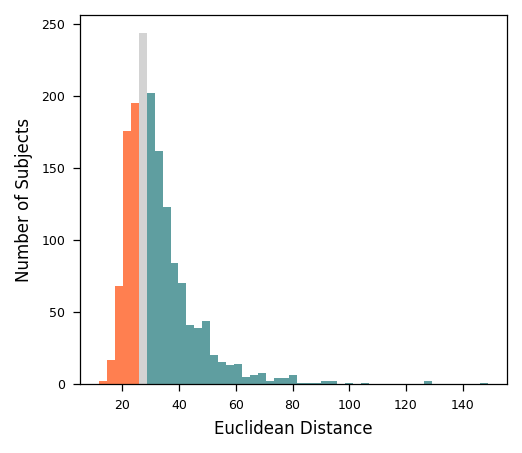

High change threshold (75th percentile): 29.787213546115176
Low change threshold (25th percentile): 24.910428005386812


In [22]:
high_diet_change_subjects, low_diet_change_subjects = distance_hist(measured_baseline[all_features], measured_02_visit[all_features], "longitudinal_distance_of_diet_changes.png")

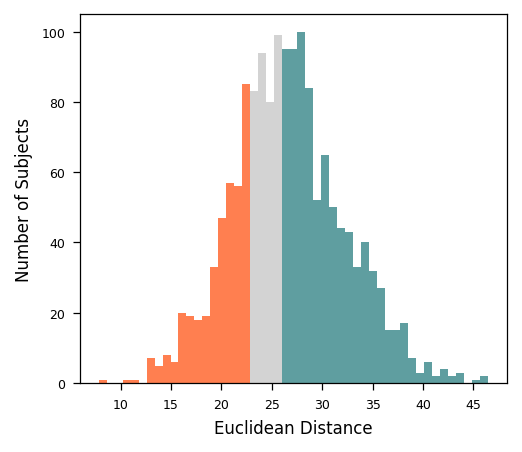

High change threshold (75th percentile): 26.34513044370984
Low change threshold (25th percentile): 22.937738278897868


In [23]:
high_mb_change_subjects, low_mb_change_subjects = distance_hist(measured_baseline[targets], measured_02_visit[targets], "longitudinal_distance_of_microbiome_changes.png")

In [24]:
high_diet_change_subjects

Index(['10K_1001201093', '10K_1007400622', '10K_1009247427', '10K_1019174630',
       '10K_1020360784', '10K_1021660035', '10K_1027123179', '10K_1048446667',
       '10K_1049983648', '10K_1061997659',
       ...
       '10K_9872133113', '10K_9887988432', '10K_9896922609', '10K_9913499422',
       '10K_9925851038', '10K_9929204951', '10K_9949511818', '10K_9952952835',
       '10K_9953095892', '10K_9963641589'],
      dtype='object', name='RegistrationCode', length=788)

In [25]:
def subset_df(measured_baseline, measured_02_visit, predicted_baseline_df, predicted_02_visit_df, subset_subjects):
    measured_baseline = measured_baseline.loc[measured_baseline.index.isin(subset_subjects)]
    measured_02_visit = measured_02_visit.loc[measured_02_visit.index.isin(subset_subjects)]
    predicted_baseline_df = predicted_baseline_df.loc[predicted_baseline_df.index.isin(subset_subjects)]
    predicted_02_visit_df = predicted_02_visit_df.loc[predicted_02_visit_df.index.isin(subset_subjects)]
    return measured_baseline, measured_02_visit, predicted_baseline_df, predicted_02_visit_df

subset_mapping = {
    'high_change_diet': high_diet_change_subjects,
    'low_change_diet': low_diet_change_subjects,
    'high_change_abundance': high_mb_change_subjects,
    'low_change_abundance': low_mb_change_subjects,
}

# Subset the DataFrames based on the selected subjects
if SUBSET in subset_mapping:
    subset_subjects = subset_mapping[SUBSET]
    measured_baseline, measured_02_visit, predicted_baseline_df, predicted_02_visit_df = subset_df(
        measured_baseline, measured_02_visit, predicted_baseline_df, predicted_02_visit_df, subset_subjects
    )

## Analysis

In [26]:
measured_02_visit[significant_targets]

,fBin__100_gBin__473_sBin__693,fBin__100_gBin__473_sBin__694,fBin__100_gBin__477_sBin__698,fBin__100_gBin__481_sBin__704,fBin__100_gBin__481_sBin__705,fBin__100_gBin__481_sBin__706,fBin__100_gBin__483_sBin__709,fBin__102_gBin__490_sBin__721,fBin__102_gBin__490_sBin__722,fBin__103_gBin__491_sBin__727,...,fBin__86_gBin__423_sBin__620,fBin__86_gBin__429_sBin__631,fBin__88_gBin__434_sBin__637,fBin__94_gBin__448_sBin__654,fBin__94_gBin__449_sBin__656,fBin__95_gBin__450_sBin__659,fBin__96_gBin__457_sBin__669,fBin__97_gBin__462_sBin__676,fBin__97_gBin__462_sBin__678,fBin__99_gBin__469_sBin__687
RegistrationCode,,,,,,,,,,,,,,,,,,,,,
10K_1001201093,-0.254961,-0.255589,1.163179,-0.318362,-0.359678,-0.445961,1.804079,1.590067,-0.272708,-0.373165,...,1.059230,-0.713026,-0.557742,0.618758,-0.311122,-0.245562,-0.237235,-0.273951,-0.046549,-0.412616
10K_1002254441,-0.254961,-0.255589,-1.007000,-0.318362,-0.359678,-0.445961,-0.641493,0.671785,-0.272708,2.504023,...,-0.130330,-0.713026,-0.557742,1.617511,-0.311122,-0.245562,-0.237235,-0.273951,2.490760,-0.412616
10K_1007400622,-0.254961,-0.255589,-0.101902,2.382378,-0.359678,2.547190,1.629267,-0.939106,1.226959,-0.373165,...,-1.473297,-0.713026,-0.557742,-0.796220,-0.311122,-0.245562,-0.237235,-0.273951,-0.791686,-0.412616
10K_1008294272,-0.254961,-0.255589,1.112501,-0.318362,-0.359678,-0.445961,1.839277,-0.939106,2.545709,-0.373165,...,-0.880945,-0.713026,-0.557742,1.453600,-0.311122,-0.245562,-0.237235,-0.273951,0.552567,-0.412616
10K_1009247427,-0.254961,-0.255589,0.789849,-0.318362,-0.359678,-0.445961,-0.641493,-0.939106,-0.272708,-0.373165,...,-0.878997,-0.713026,-0.557742,-0.796220,-0.311122,-0.245562,-0.237235,0.572241,-0.264680,-0.412616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10K_9949511818,-0.254961,-0.255589,1.078583,-0.318362,-0.359678,-0.445961,1.738656,-0.939106,-0.272708,-0.373165,...,-1.473297,-0.713026,-0.557742,-0.796220,-0.311122,-0.245562,-0.237235,-0.273951,-0.791686,-0.412616
10K_9952952835,-0.254961,-0.255589,-1.007000,-0.318362,-0.359678,-0.445961,-0.641493,-0.939106,-0.272708,-0.373165,...,0.981756,-0.713026,-0.557742,-0.796220,-0.311122,-0.245562,-0.237235,-0.273951,2.514917,-0.412616
10K_9953095892,-0.254961,-0.255589,1.296167,-0.318362,-0.359678,-0.445961,-0.641493,1.577395,-0.272708,-0.373165,...,0.780608,1.172048,0.618863,0.151955,-0.311122,-0.245562,-0.237235,-0.273951,0.583387,-0.412616


In [27]:
pred_baseline_scores = pred_baseline_scores.loc[significant_targets_indices]
pred_02_visit_scores = pred_02_visit_scores.loc[significant_targets_indices]
pred_04_visit_scores = pred_04_visit_scores.loc[significant_targets_indices]
pred_baseline_scores

0      0.068938
1      0.059387
3      0.135060
4      0.039714
5     -0.002861
         ...   
719    0.044922
720    0.101665
721    0.031756
722    0.037590
723    0.099890
Name: 0, Length: 664, dtype: float64

In [28]:
lgbm_diet_scores = lgbm_diet_scores.loc[significant_targets_indices]
lgbm_diet_scores

0      0.049718
1      0.069676
3      0.120000
4      0.051829
5      0.043712
         ...   
719    0.029393
720    0.066482
721    0.053365
722    0.055417
723    0.087675
Name: 0, Length: 664, dtype: float64

In [29]:
if TARGETS == 'abundance':
    # targets = significant_targets
    baseline_corr = lgbm_diet_scores

In [30]:
from scipy.stats import pearsonr

r_baseline, p_baseline = pearsonr(baseline_corr, pred_baseline_scores)
print(f"Pearson R = {r_baseline:.2f}, p = {p_baseline:.2e}")

r_02, p_02 = pearsonr(baseline_corr, pred_02_visit_scores)
print(f"Pearson R = {r_02:.2f}, p = {p_02:.2e}")

r_04, p_04 = pearsonr(baseline_corr, pred_04_visit_scores)
print(f"Pearson R = {r_04:.2f}, p = {p_04:.2e}")

Pearson R = 0.90, p = 3.83e-243
Pearson R = 0.90, p = 7.72e-240
Pearson R = 0.89, p = 9.37e-226


In [31]:
from sklearn.metrics import r2_score

r2_baseline = r2_score(baseline_corr, pred_baseline_scores)
r2_02 = r2_score(baseline_corr, pred_02_visit_scores)
r2_04 = r2_score(baseline_corr, pred_04_visit_scores)

print(f"R² vs Cross-validated correlations:")
print(f"  Baseline held-out: {r2_baseline:.3f}")
print(f"  Visit 02: {r2_02:.3f}")
print(f"  Visit 04: {r2_04:.3f}")

R² vs Cross-validated correlations:
  Baseline held-out: 0.728
  Visit 02: 0.793
  Visit 04: 0.766


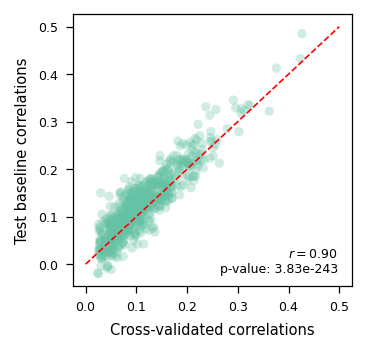

<Figure size 360x360 with 0 Axes>

In [92]:
# How well did the model predict the microbiome from diet on baseline and on intervention?
if TARGETS == 'abundance':
    # targets = significant_targets
    baseline_corr = lgbm_diet_scores
elif TARGETS == 'div':
    baseline_corr = lgbm_div_scores

plt.rcParams["figure.dpi"] = 150
plt.style.use(third_style)
# U, p = stats.wilcoxon(baseline_corr, pred_baseline_scores)
to_plot = pd.concat([baseline_corr, pred_baseline_scores] , axis=1)
to_plot.columns = ["Cross-validated correlations", "Test baseline correlations"]
to_plot.plot.scatter("Cross-validated correlations", "Test baseline correlations", color=color1, alpha=0.3, edgecolor="none")
# plt.title("Cross-validated correlations VS Test baseline correlations")
plt.plot([0, 0.5], [0, 0.5], 'r--')
# plt.grid()
# plt.text(0.25, plt.ylim()[0] + 0.05 * (plt.ylim()[1] - plt.ylim()[0]), f'p-value: {p:.2f}', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='white'))
x0, x1 = plt.xlim()
y0, y1 = plt.ylim()
plt.text(
    x1 - 0.05 * (x1 - x0),
    y0 + 0.04 * (y1 - y0),
    f'$r = {r_baseline:.2f}$\np-value: {p_baseline:.2e}',
    ha='right', va='bottom',
    bbox=dict(facecolor='white', edgecolor='white')
)

plt.savefig(home_path + f"figures/longitudinal/{SUBSET}/predicted_baseline_VS_original_" + TARGETS + ".png", dpi=400, facecolor="white", transparent=False, bbox_inches='tight')
plt.show()
plt.clf()


0.972090899322633


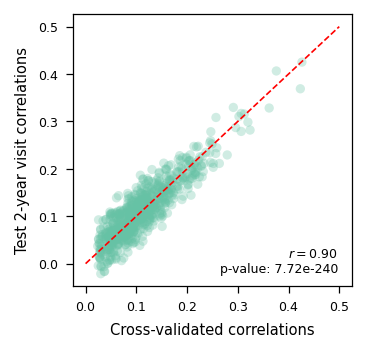

<Figure size 360x360 with 0 Axes>

In [93]:
# How well did the model predict the microbiome from diet on baseline and on intervention?

if TARGETS == 'abundance':
    baseline_corr = lgbm_diet_scores
elif TARGETS == 'div':
    baseline_corr = lgbm_div_scores

# U, p = stats.mannwhitneyu(baseline_corr, pred_02_visit_scores, alternative='two-sided')
U, p = stats.wilcoxon(baseline_corr, pred_02_visit_scores)
print(p)
to_plot = pd.concat([baseline_corr, pred_02_visit_scores] , axis=1)
to_plot.columns = ["Cross-validated correlations", "Test 2-year visit correlations"]
to_plot.plot.scatter("Cross-validated correlations", "Test 2-year visit correlations", color=color1, alpha=0.3, edgecolor="none")
# plt.title("Cross-validated correlations VS Test 2-year visit correlations")
plt.plot([0, 0.5], [0, 0.5], 'r--')
# plt.grid()
x0, x1 = plt.xlim()
y0, y1 = plt.ylim()
plt.text(
    x1 - 0.05 * (x1 - x0),
    y0 + 0.04 * (y1 - y0),
    f'$r = {r_02:.2f}$\np-value: {p_02:.2e}',
    ha='right', va='bottom',
    bbox=dict(facecolor='white', edgecolor='white')
)
plt.savefig(home_path + f"figures/longitudinal/{SUBSET}/predicted_02_visit_VS_original_" + TARGETS + ".png", dpi=400, facecolor="white", transparent=False, bbox_inches='tight')
plt.show()
plt.clf()


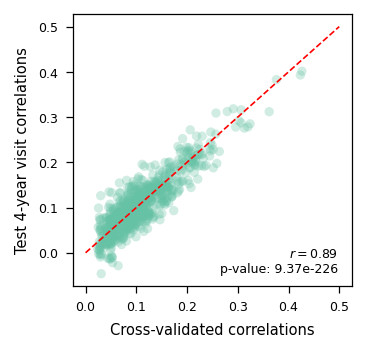

<Figure size 360x360 with 0 Axes>

In [94]:
# How well did the model predict the microbiome from diet on baseline and on intervention?

if TARGETS == 'abundance':
    baseline_corr = lgbm_diet_scores
elif TARGETS == 'div':
    baseline_corr = lgbm_div_scores

U, p = stats.wilcoxon(baseline_corr, pred_04_visit_scores)
to_plot = pd.concat([baseline_corr, pred_04_visit_scores] , axis=1)
to_plot.columns = ["Cross-validated correlations", "Test 4-year visit correlations"]
to_plot.plot.scatter("Cross-validated correlations", "Test 4-year visit correlations", color=color1, alpha=0.3, edgecolor="none")
# plt.title("Cross-validated correlations VS Test 4-year visit correlations")
plt.plot([0, 0.5], [0, 0.5], 'r--')
# plt.grid()
x0, x1 = plt.xlim()
y0, y1 = plt.ylim()
plt.text(
    x1 - 0.05 * (x1 - x0),
    y0 + 0.04 * (y1 - y0),
    f'$r = {r_04:.2f}$\np-value: {p_04:.2e}',
    ha='right', va='bottom',
    bbox=dict(facecolor='white', edgecolor='white')
)
plt.savefig(home_path + f"figures/longitudinal/{SUBSET}/predicted_04_visit_VS_original_" + TARGETS + ".png", dpi=400, facecolor="white", transparent=False, bbox_inches='tight')
plt.show()
plt.clf()


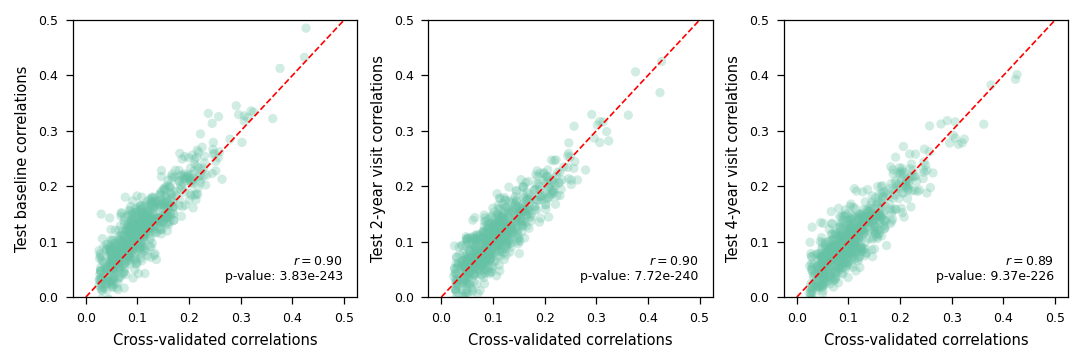

In [104]:
plt.style.use(double_style)

def scatter_panel(ax, x, y, xlab, ylab, r_val, p_val):
    to_plot = pd.concat([x, y], axis=1)
    to_plot.columns = [xlab, ylab]
    to_plot.plot.scatter(
        xlab, ylab,
        color=color1, alpha=0.3, edgecolor="none", ax=ax
    )
    ax.plot([0, 0.5], [0, 0.5], 'r--')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.text(
        0.95, 0.05,
        rf'$r = {r_val:.2f}$' + f'\np-value: {p_val:.2e}',
        ha='right', va='bottom',
        transform=ax.transAxes,
        bbox=dict(facecolor='white', edgecolor='white')
    )

# Choose baseline_corr according to TARGETS
if TARGETS == 'abundance':
    baseline_corr = lgbm_diet_scores
elif TARGETS == 'div':
    baseline_corr = lgbm_div_scores

fig, axes = plt.subplots(1, 3)

# Subplots
scatter_panel(
    axes[0],
    baseline_corr, pred_baseline_scores,
    "Cross-validated correlations", "Test baseline correlations",
    r_baseline, p_baseline
)
scatter_panel(
    axes[1],
    baseline_corr, pred_02_visit_scores,
    "Cross-validated correlations", "Test 2-year visit correlations",
    r_02, p_02
)
scatter_panel(
    axes[2],
    baseline_corr, pred_04_visit_scores,
    "Cross-validated correlations", "Test 4-year visit correlations",
    r_04, p_04
)

# --- Fix y-axis for all panels ---
for ax in axes:
    ax.set_ylim(0, 0.5)
    ax.set_yticks(np.linspace(0, 0.5, 6))

plt.tight_layout()

out_path = home_path + f"figures/longitudinal/{SUBSET}/predicted_panel_baseline_02_04_{TARGETS}.png"
plt.savefig(out_path, dpi=400, facecolor="white", transparent=False, bbox_inches='tight')
plt.show()


In [105]:
print(measured_04_visit[significant_targets].shape)
print(measured_baseline[significant_targets].shape)
print(predicted_04_visit_df[significant_targets].shape)
print(predicted_baseline_df[significant_targets].shape)

(1294, 664)
(1576, 664)
(1294, 664)
(1576, 664)


In [106]:
print(measured_04_visit[significant_targets].index)
print(measured_baseline[significant_targets].index)
print(predicted_04_visit_df[significant_targets].index)
print(predicted_baseline_df[significant_targets].index)

Index(['10K_1012289523', '10K_1038285016', '10K_1041215021', '10K_1041888957',
       '10K_1054900789', '10K_1061361661', '10K_1069580508', '10K_1078703378',
       '10K_1087648704', '10K_1098823023',
       ...
       '10K_9926809167', '10K_9929204951', '10K_9947884210', '10K_9948270697',
       '10K_9949511818', '10K_9952952835', '10K_9953095892', '10K_9963641589',
       '10K_9976173468', '10K_9984191583'],
      dtype='object', name='RegistrationCode', length=1294)
Index(['10K_1001201093', '10K_1002254441', '10K_1007400622', '10K_1008294272',
       '10K_1009247427', '10K_1012027362', '10K_1012400211', '10K_1019174630',
       '10K_1020360784', '10K_1021660035',
       ...
       '10K_9919768321', '10K_9925851038', '10K_9926809167', '10K_9929204951',
       '10K_9948270697', '10K_9949511818', '10K_9952952835', '10K_9953095892',
       '10K_9963641589', '10K_9976173468'],
      dtype='object', name='RegistrationCode', length=1576)
Index(['10K_1012289523', '10K_1038285016', '10K_1041

In [107]:
# Real measured changes before after
delta_measured = measured_02_visit[significant_targets] - measured_baseline[significant_targets]
delta_measured_4_years = measured_04_visit[significant_targets] - measured_baseline[significant_targets]
# score = stats.pearsonr(preds, significant_targets)
delta_measured_4_years = delta_measured_4_years.dropna()
delta_measured_4_years

,fBin__100_gBin__473_sBin__693,fBin__100_gBin__473_sBin__694,fBin__100_gBin__477_sBin__698,fBin__100_gBin__481_sBin__704,fBin__100_gBin__481_sBin__705,fBin__100_gBin__481_sBin__706,fBin__100_gBin__483_sBin__709,fBin__102_gBin__490_sBin__721,fBin__102_gBin__490_sBin__722,fBin__103_gBin__491_sBin__727,...,fBin__86_gBin__423_sBin__620,fBin__86_gBin__429_sBin__631,fBin__88_gBin__434_sBin__637,fBin__94_gBin__448_sBin__654,fBin__94_gBin__449_sBin__656,fBin__95_gBin__450_sBin__659,fBin__96_gBin__457_sBin__669,fBin__97_gBin__462_sBin__676,fBin__97_gBin__462_sBin__678,fBin__99_gBin__469_sBin__687
RegistrationCode,,,,,,,,,,,,,,,,,,,,,
10K_1038285016,0.000000,0.000000,-1.089434,0.000000,0.000000,0.000000,1.979210,0.000000,0.0,0.0,...,0.937436,0.000000,0.298423,0.679238,0.0,0.000000,0.0,0.000000,0.000000,0.000000
10K_1041888957,0.000000,0.000000,2.889843,0.000000,0.000000,0.000000,0.000000,2.146486,0.0,0.0,...,0.454589,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
10K_1054900789,0.000000,0.000000,-0.263330,-2.546032,-0.080683,-0.021162,1.528141,0.271435,0.0,0.0,...,1.437948,0.000000,0.000000,-1.329960,0.0,-3.374187,0.0,0.000000,0.000000,0.000000
10K_1061361661,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.605263,0.0,0.0,...,-0.903331,-0.615247,0.000000,0.000000,0.0,0.000000,0.0,-0.252871,-0.216546,0.756481
10K_1087648704,0.751449,0.102713,0.000000,0.000000,0.000000,0.000000,0.000000,-2.820978,0.0,0.0,...,3.410491,0.000000,3.811910,0.000000,0.0,0.000000,0.0,0.000000,2.090609,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10K_9949511818,0.000000,0.000000,-1.806904,0.000000,0.000000,0.000000,-1.907598,2.012224,0.0,0.0,...,-1.509190,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
10K_9952952835,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,1.957511,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.301446,0.000000
10K_9953095892,0.000000,0.000000,-1.226827,0.000000,0.000000,0.000000,0.000000,-0.409105,0.0,0.0,...,-1.020248,1.390493,-1.327592,-1.348806,0.0,0.000000,0.0,0.000000,-1.012469,0.000000


In [108]:
delta_predicted = predicted_02_visit_df[significant_targets] - predicted_baseline_df[significant_targets]
delta_predicted_4_years = predicted_04_visit_df[significant_targets] - predicted_baseline_df[significant_targets]
delta_predicted_4_years = delta_predicted_4_years.dropna()
delta_predicted_4_years

,fBin__100_gBin__473_sBin__693,fBin__100_gBin__473_sBin__694,fBin__100_gBin__477_sBin__698,fBin__100_gBin__481_sBin__704,fBin__100_gBin__481_sBin__705,fBin__100_gBin__481_sBin__706,fBin__100_gBin__483_sBin__709,fBin__102_gBin__490_sBin__721,fBin__102_gBin__490_sBin__722,fBin__103_gBin__491_sBin__727,...,fBin__86_gBin__423_sBin__620,fBin__86_gBin__429_sBin__631,fBin__88_gBin__434_sBin__637,fBin__94_gBin__448_sBin__654,fBin__94_gBin__449_sBin__656,fBin__95_gBin__450_sBin__659,fBin__96_gBin__457_sBin__669,fBin__97_gBin__462_sBin__676,fBin__97_gBin__462_sBin__678,fBin__99_gBin__469_sBin__687
RegistrationCode,,,,,,,,,,,,,,,,,,,,,
10K_1038285016,0.035881,-0.046162,-0.082220,-0.020777,0.033060,-0.068234,0.003879,0.050074,0.043305,-0.024872,...,0.015744,-0.029579,-0.016566,0.032244,-0.001994,0.047107,-0.047372,0.021010,0.039140,0.039963
10K_1041888957,-0.063081,0.014371,0.019786,-0.011741,0.087948,-0.050754,-0.009895,0.007940,0.088576,-0.016556,...,0.022002,-0.035720,-0.041838,0.081641,-0.062556,-0.021320,-0.017671,-0.059024,-0.049039,-0.005905
10K_1054900789,-0.040505,0.088550,0.006910,0.026985,0.063888,-0.027721,0.078618,-0.107186,-0.069604,0.012723,...,-0.051841,0.134618,0.041247,-0.091754,-0.003182,0.002862,0.025429,0.077330,-0.100965,0.062139
10K_1061361661,-0.057814,0.026572,0.004555,-0.016667,-0.011644,0.027066,-0.008092,-0.007746,-0.097327,0.067775,...,0.021190,0.090667,0.141441,-0.009080,-0.109065,0.071073,0.039738,0.061753,0.020530,0.072268
10K_1087648704,-0.003642,-0.022362,-0.036546,-0.008038,0.067062,0.004380,0.063611,0.134853,0.005535,-0.020031,...,0.067018,0.080490,-0.064886,0.115061,0.011649,-0.132999,-0.006734,-0.033958,0.055098,-0.032676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10K_9949511818,-0.039621,0.041947,-0.099729,-0.008922,-0.000306,0.030634,-0.070886,-0.010041,-0.006199,-0.046829,...,-0.060644,0.045359,-0.106076,0.093237,0.000266,-0.026271,0.007976,0.040205,0.026754,0.050880
10K_9952952835,-0.001283,0.009006,-0.074708,-0.055954,-0.007092,-0.004732,-0.004348,-0.016160,0.065583,0.064793,...,0.044976,0.027905,0.030397,-0.089559,-0.052568,-0.069984,0.002988,0.008547,0.016882,-0.008618
10K_9953095892,-0.115443,-0.134275,0.200015,0.105706,0.039785,0.159882,-0.260170,-0.233475,0.008121,-0.144627,...,-0.149969,-0.425335,-0.173591,-0.035247,-0.029332,0.042970,-0.135447,-0.098604,-0.105175,0.178334


In [109]:
if TARGETS == 'abundance':
    # Is there measured change in the yogurt, coffee and nuts microbes?
    print("S. Thermophilus:\n", delta_measured["fBin__187_gBin__748_sBin__1116"].describe(), "\n")
    print("Lawsonibacter:\n", delta_measured["fBin__541_gBin__2135_sBin__3290"].describe(), "\n")
    print("Nuts microbe:\n", delta_measured["fBin__367_gBin__1458_sBin__2166"].describe(), "\n")

S. Thermophilus:
 count    1576.000000
mean        0.026491
std         1.234953
min        -5.699964
25%        -0.366504
50%         0.000000
75%         0.411923
max         4.518634
Name: fBin__187_gBin__748_sBin__1116, dtype: float64 

Lawsonibacter:
 count    1576.000000
mean        0.068287
std         0.918235
min        -3.855903
25%        -0.448143
50%         0.000000
75%         0.593375
max         3.202992
Name: fBin__541_gBin__2135_sBin__3290, dtype: float64 

Nuts microbe:
 count    1576.000000
mean       -0.036792
std         1.087454
min        -3.560650
25%        -0.719832
50%         0.000000
75%         0.582504
max         3.745355
Name: fBin__367_gBin__1458_sBin__2166, dtype: float64 



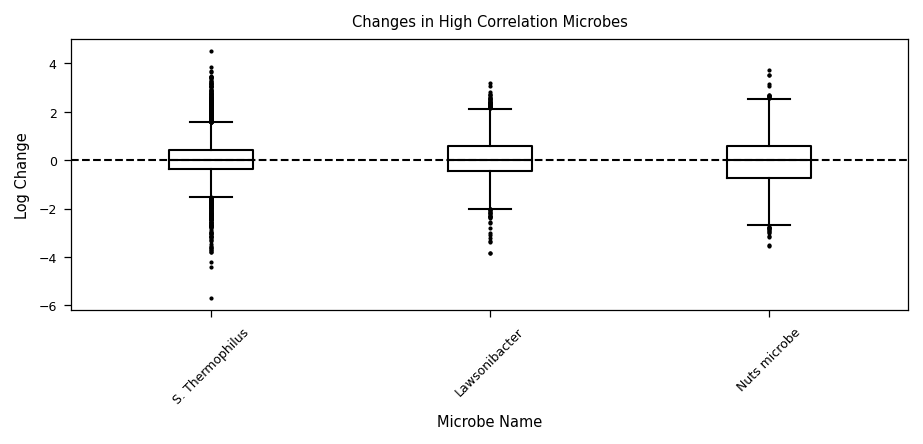

In [110]:
if TARGETS == 'abundance':    
    fig, ax = plt.subplots()
    plt.axhline(0, color='black', linewidth=1, linestyle='--')
    ax.boxplot([delta_measured["fBin__187_gBin__748_sBin__1116"], delta_measured["fBin__541_gBin__2135_sBin__3290"], delta_measured["fBin__367_gBin__1458_sBin__2166"]], labels=["S. Thermophilus", "Lawsonibacter", "Nuts microbe"], #patch_artist=False, notch=True, boxprops=dict(color='black'), 
                    medianprops=dict(color='black'),
                    flierprops=dict(marker='.', color='black', markersize=2, alpha=1))
    ax.set_xlabel("Microbe Name")
    ax.set_ylabel("Log Change")
    ax.set_title("Changes in High Correlation Microbes")
    plt.xticks(rotation=45)
    plt.savefig(home_path + f"figures/longitudinal/{SUBSET}/changes_in_high_corr_microbes.png", dpi=400, facecolor="white", transparent=False, bbox_inches='tight')
    plt.show()

if TARGETS == 'div':    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Richness subplot
    axes[0].axhline(0, color='black', linewidth=1, linestyle='--')
    axes[0].boxplot(delta_measured["Richness"], labels=["Richness"],
                    medianprops=dict(color='black'),
                    flierprops=dict(marker='.', color='black', markersize=2, alpha=1))
    axes[0].set_title("Changes in Richness")

    # Shannon diversity subplot
    axes[1].axhline(0, color='black', linewidth=1, linestyle='--')
    axes[1].boxplot(delta_measured["Shannon_diversity"], labels=["Shannon Diversity"],
                    medianprops=dict(color='black'),
                    flierprops=dict(marker='.', color='black', markersize=2, alpha=1))
    axes[1].set_title("Changes in Shannon Diversity")

    # Adjust layout
    plt.tight_layout()
    plt.savefig(home_path + f"figures/longitudinal/{SUBSET}/changes_in_diversity.png", dpi=400, facecolor="white", transparent=False, bbox_inches='tight')
    plt.show()

In [111]:
# Is there change in the dietary consumption of yogurt, coffee or nuts?
delta_measured_features = measured_02_visit[all_features] - measured_baseline[all_features]
delta_measured_features

,Acorn_squash,Alfalfa_sprouts,Almond_Beverage,Almond_flour,Almond_spread,Almonds,Amba,Apple,Apple_Cake,Apple_Vinegar,...,Spicesandherbs,Vegetables,bakedgoods,fruitjuicesandsoftdrinks,milkcreamcheeseandyogurts,sweetmilkproducts,sweets,age,sex,Energy___BMR
RegistrationCode,,,,,,,,,,,,,,,,,,,,,
10K_1001201093,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,-0.103617,0.000000,0.0,...,0.000000,-1.822647,0.000000,-1.258861,4.834283,-2.213514,0.782546,0.260826,0.0,0.815565
10K_1002254441,0.0,0.0,0.0,0.000000,0.0,-3.232284,0.0,0.322802,0.000000,0.0,...,0.000000,-1.923726,0.000000,0.000000,-0.014824,0.000000,0.630230,0.260826,0.0,-0.148405
10K_1007400622,0.0,0.0,0.0,0.000000,0.0,3.052706,0.0,0.000000,0.000000,0.0,...,0.000000,1.515122,-0.247968,0.000000,-0.232005,-0.671990,-0.555407,0.260826,0.0,-0.368170
10K_1008294272,0.0,0.0,0.0,0.000000,0.0,-0.984474,0.0,0.000000,0.000000,0.0,...,0.000000,-0.129525,0.000000,0.000000,0.163754,0.000000,-0.775737,0.260826,0.0,-0.668172
10K_1009247427,0.0,0.0,0.0,0.000000,0.0,0.386845,0.0,-0.059309,0.000000,0.0,...,-0.184866,2.139085,0.000000,-0.056700,2.903800,1.060368,-0.992730,0.260826,0.0,-1.871422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10K_9949511818,0.0,0.0,0.0,0.000000,0.0,0.023049,0.0,-0.100133,0.000000,0.0,...,-0.014987,0.945023,1.842594,-3.023786,-1.870185,0.000000,0.206784,0.260826,0.0,-0.283290
10K_9952952835,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,-0.236273,0.000000,0.0,...,0.305250,-0.116405,0.000000,0.000000,-0.957231,0.000000,-0.221191,0.260826,0.0,-2.036333
10K_9953095892,0.0,0.0,0.0,-26.326058,0.0,0.837195,0.0,0.518422,0.000000,0.0,...,0.000000,-0.204830,0.000000,0.000000,0.360248,0.000000,-0.315364,0.260826,0.0,1.204522


In [112]:

# # Create a figure with 4 subplots arranged in 2x2
# fig, axes = plt.subplots(2, 2, figsize=(12, 10))
# axes = axes.flatten()  # Flatten the 2x2 array to make indexing easier
# positions = [1, 2]

# # List of food items
# foods = ["Yogurt", "Coffee", "Almonds", "Walnuts"]

# for idx, food in enumerate(foods):
#     # Assuming 'baseline_diet_mb' and 'intervention_diet_mb' are defined with each food type
#     data = pd.DataFrame({
#         "Baseline": measured_baseline[food],
#         "2nd Visit": measured_02_visit[food]
#     })

#     # Plotting for each food
#     ax = axes[idx]
#     for i, col in enumerate(data.columns):
#         y = data[col]
#         x = [positions[i]] * len(y)
#         ax.scatter(x, y, alpha=0.7)

#     # Connect dots between points
#     for i in range(len(data)):
#         ax.plot([1, 2], [data['Baseline'].iloc[i], data['2nd Visit'].iloc[i]], color='grey', alpha=0.1)

#     ax.set_xticks([1, 2])
#     ax.set_xticklabels(['Baseline', '2nd Visit'])
#     ax.set_title(f"Comparison of {food} Consumption")
#     ax.set_ylabel("Z score")

# # Adjust layout to prevent overlap
# plt.tight_layout()
# plt.savefig(home_path + f"figures/longitudinal/{SUBSET}/changes_in_food_consumption.png", dpi=400, facecolor="white", transparent=False, bbox_inches='tight')
# plt.show()


In [113]:
if TARGETS == 'abundance':
    with open(f'/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/{SPECIES}/my_lists.pkl', 'rb') as file:
        loaded_lists = pickle.load(file)
    _, _, target_input = loaded_lists
    target_input = [re.sub(r'[^a-zA-Z0-9_]', '_', x) for x in target_input]
    lgbm_diet_scores_codes = lgbm_diet_scores.copy()
    # lgbm_diet_scores_codes.index = [targets[i] for i in lgbm_diet_scores_codes.index]
    lgbm_diet_scores_codes.index = [target_input[i] for i in lgbm_diet_scores_codes.index]

    print(lgbm_diet_scores_codes)

fBin__100_gBin__473_sBin__693    0.049718
fBin__100_gBin__473_sBin__694    0.069676
fBin__100_gBin__477_sBin__698    0.120000
fBin__100_gBin__481_sBin__704    0.051829
fBin__100_gBin__481_sBin__705    0.043712
                                   ...   
fBin__95_gBin__450_sBin__659     0.029393
fBin__96_gBin__457_sBin__669     0.066482
fBin__97_gBin__462_sBin__676     0.053365
fBin__97_gBin__462_sBin__678     0.055417
fBin__99_gBin__469_sBin__687     0.087675
Name: 0, Length: 664, dtype: float64


In [114]:
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

def calculate_correlations(delta_measured, delta_predicted):
    results = {}
    pearson_p_values = []
    spearman_p_values = []

    for column in delta_measured.columns:
        if column in delta_predicted.columns:
            # Compute Pearson correlation
            pearson_corr, pearson_p_val = stats.pearsonr(delta_measured[column], delta_predicted[column])
            pearson_p_values.append(pearson_p_val)

            # Compute Spearman correlation
            spearman_corr, spearman_p_val = stats.spearmanr(delta_measured[column], delta_predicted[column])
            spearman_p_values.append(spearman_p_val)

            # Store results
            results[column] = {
                'Pearson Correlation': pearson_corr,
                'Pearson Pval': pearson_p_val,
                'Spearman Correlation': spearman_corr,
                'Spearman Pval': spearman_p_val
            }

    # Adjust the p-values for multiple testing using FDR
    pearson_p_adjusted = multipletests(pearson_p_values, method='fdr_bh')[1]
    spearman_p_adjusted = multipletests(spearman_p_values, method='fdr_bh')[1]

    # Add adjusted p-values to the results
    for i, column in enumerate(results):
        results[column]['Pearson Pval_adj'] = pearson_p_adjusted[i]
        results[column]['Spearman Pval_adj'] = spearman_p_adjusted[i]

    results_df = pd.DataFrame(results).T  # Transpose to have columns as keys


    # Define the desired column order
    column_order = [
        'Pearson Correlation', 'Pearson Pval', 'Pearson Pval_adj',
        'Spearman Correlation', 'Spearman Pval', 'Spearman Pval_adj'
    ]

    # Reorder the columns according to the specified order
    results_df = results_df[column_order]

    return results_df

results_df_2_years = calculate_correlations(delta_measured, delta_predicted)
results_df_4_years = calculate_correlations(delta_measured_4_years, delta_predicted_4_years)
results_df_2_years

,Pearson Correlation,Pearson Pval,Pearson Pval_adj,Spearman Correlation,Spearman Pval,Spearman Pval_adj
fBin__100_gBin__473_sBin__693,0.023667,0.347769,0.598016,0.000778,0.975379,0.985136
fBin__100_gBin__473_sBin__694,-0.006884,0.784782,0.892645,-0.016411,0.515041,0.754939
fBin__100_gBin__477_sBin__698,0.024420,0.332640,0.587427,0.012052,0.632574,0.821359
fBin__100_gBin__481_sBin__704,0.017567,0.485860,0.713664,0.027539,0.274573,0.567964
fBin__100_gBin__481_sBin__705,-0.002231,0.929482,0.972653,0.022580,0.370350,0.643750
...,...,...,...,...,...,...
fBin__95_gBin__450_sBin__659,-0.003620,0.885823,0.956824,-0.020291,0.420830,0.683206
fBin__96_gBin__457_sBin__669,0.078875,0.001726,0.016614,0.053818,0.032649,0.146479
fBin__97_gBin__462_sBin__676,-0.023967,0.341690,0.595491,-0.026774,0.288123,0.579738
fBin__97_gBin__462_sBin__678,0.004123,0.870089,0.947113,0.007734,0.759013,0.887297


In [115]:

# results = {}
# pearson_p_values = []
# spearman_p_values = []

# for column in delta_measured.columns:
#     if column in delta_predicted.columns:
#         # Compute Pearson correlation
#         pearson_corr, pearson_p_val = stats.pearsonr(delta_measured[column], delta_predicted[column])
#         pearson_p_values.append(pearson_p_val)

#         # Compute Spearman correlation
#         spearman_corr, spearman_p_val = stats.spearmanr(delta_measured[column], delta_predicted[column])
#         spearman_p_values.append(spearman_p_val)

#         # Store results
#         results[column] = {
#             'Pearson Correlation': pearson_corr,
#             'Pearson Pval': pearson_p_val,
#             'Spearman Correlation': spearman_corr,
#             'Spearman Pval': spearman_p_val
#         }

# # Adjust the p-values for multiple testing using FDR
# pearson_p_adjusted = multipletests(pearson_p_values, method='fdr_bh')[1]
# spearman_p_adjusted = multipletests(spearman_p_values, method='fdr_bh')[1]

# # Add adjusted p-values to the results
# for i, column in enumerate(results):
#     results[column]['Pearson Pval_adj'] = pearson_p_adjusted[i]
#     results[column]['Spearman Pval_adj'] = spearman_p_adjusted[i]

# results_df = pd.DataFrame(results).T  # Transpose to have columns as keys


# # Define the desired column order
# column_order = [
#     'Pearson Correlation', 'Pearson Pval', 'Pearson Pval_adj',
#     'Spearman Correlation', 'Spearman Pval', 'Spearman Pval_adj'
# ]

# # Reorder the columns according to the specified order
# results_df = results_df[column_order]

# results_df

In [116]:
if TARGETS == 'abundance':
    def FDR_training_corr_order(lgbm_diet_scores_codes, p_values_col, results_df, col_name):
        # Ensure that the sorted indices and the p-values are properly aligned
        # Sort lgbm_diet_scores_codes and the corresponding Pearson p-values in the same order
        p_values = results_df[p_values_col]
        sorted_indices = lgbm_diet_scores_codes.sort_values().index
        sorted_indices = sorted_indices[sorted_indices.isin(results_df.index)]
        new_rank = pd.Series(range(1, len(sorted_indices) + 1), index=sorted_indices)
        # print(new_rank)

        # Align the Pearson p-values with the sorted indices
        p_values_series = pd.Series(p_values, index=results_df.index)
        sorted_p_values = p_values_series.reindex(sorted_indices)

        # Calculate the new FDR
        new_fdr = sorted_p_values * len(sorted_indices) / new_rank

        # Clip FDR values to be <= 1
        new_fdr = new_fdr.clip(upper=1)

        # Add the new FDR to sorted_results_df
        results_df[col_name] = new_fdr.reindex(results_df.index)

        return results_df
    
    results_df_2_years = FDR_training_corr_order(lgbm_diet_scores_codes, "Pearson Pval", results_df_2_years, "Pearson_Pval_adj_training_corr_order")
    results_df_2_years = FDR_training_corr_order(lgbm_diet_scores_codes, "Spearman Pval", results_df_2_years, "Spearman_Pval_adj_training_corr_order")
    results_df_4_years = FDR_training_corr_order(lgbm_diet_scores_codes, "Pearson Pval", results_df_4_years, "Pearson_Pval_adj_training_corr_order")
    results_df_4_years = FDR_training_corr_order(lgbm_diet_scores_codes, "Spearman Pval", results_df_4_years, "Spearman_Pval_adj_training_corr_order")
   

In [117]:
# # Optionally sort by one of the correlation metrics
# sorted_results_df = results_df.sort_values(by="Pearson Correlation", ascending=False)

# sorted_results_df

In [118]:
if TARGETS == 'abundance':
    # result_df = correlations.to_frame(name='real_pred_delta_corr')
    results_df_2_years['species'] = results_df_2_years.index.map(mb_names['species_new'])
    results_df_4_years['species'] = results_df_4_years.index.map(mb_names['species_new'])

    print(results_df_2_years)

                               Pearson Correlation  Pearson Pval  \
fBin__100_gBin__473_sBin__693             0.023667      0.347769   
fBin__100_gBin__473_sBin__694            -0.006884      0.784782   
fBin__100_gBin__477_sBin__698             0.024420      0.332640   
fBin__100_gBin__481_sBin__704             0.017567      0.485860   
fBin__100_gBin__481_sBin__705            -0.002231      0.929482   
...                                            ...           ...   
fBin__95_gBin__450_sBin__659             -0.003620      0.885823   
fBin__96_gBin__457_sBin__669              0.078875      0.001726   
fBin__97_gBin__462_sBin__676             -0.023967      0.341690   
fBin__97_gBin__462_sBin__678              0.004123      0.870089   
fBin__99_gBin__469_sBin__687              0.089072      0.000400   

                               Pearson Pval_adj  Spearman Correlation  \
fBin__100_gBin__473_sBin__693          0.598016              0.000778   
fBin__100_gBin__473_sBin__694        

In [119]:
def add_prevalence_columns(results_df, measured_baseline, measured_visit, diet_mb_train, significant_targets):
    results_df['test_prevalence_baseline'] = results_df.index.map(
        lambda row_index: measured_baseline[measured_baseline[row_index] > measured_baseline[row_index].min()].shape[0]
    )

    results_df['test_prevalence_visit'] = results_df.index.map(
        lambda row_index: measured_visit[measured_visit[row_index] > measured_visit[row_index].min()].shape[0]
    )

    results_df['train_prevalence_baseline'] = results_df.index.map(
        lambda row_index: diet_mb_train[significant_targets][diet_mb_train[significant_targets][row_index] > diet_mb_train[significant_targets][row_index].min()].shape[0]
    )


add_prevalence_columns(results_df_2_years, measured_baseline, measured_02_visit, diet_mb_train, significant_targets)
add_prevalence_columns(results_df_4_years, measured_baseline, measured_04_visit, diet_mb_train, significant_targets)
results_df_2_years['train_prevalence_baseline']

fBin__100_gBin__473_sBin__693     696
fBin__100_gBin__473_sBin__694     697
fBin__100_gBin__477_sBin__698    4735
fBin__100_gBin__481_sBin__704     913
fBin__100_gBin__481_sBin__705    1166
                                 ... 
fBin__95_gBin__450_sBin__659      492
fBin__96_gBin__457_sBin__669      529
fBin__97_gBin__462_sBin__676      745
fBin__97_gBin__462_sBin__678     4817
fBin__99_gBin__469_sBin__687     1429
Name: train_prevalence_baseline, Length: 664, dtype: int64

In [120]:
if TARGETS == 'abundance':
    results_df_2_years['significant'] = ((results_df_2_years['Pearson Correlation'] > 0) &
                                (results_df_2_years['Spearman Correlation'] > 0) &
                                (results_df_2_years['Pearson_Pval_adj_training_corr_order'] < 0.05) &
                                (results_df_2_years['Spearman_Pval_adj_training_corr_order'] < 0.05)).astype(int)
    results_df_4_years['significant'] = ((results_df_4_years['Pearson Correlation'] > 0) &
                                (results_df_4_years['Spearman Correlation'] > 0) &
                                (results_df_4_years['Pearson_Pval_adj_training_corr_order'] < 0.05) &
                                (results_df_4_years['Spearman_Pval_adj_training_corr_order'] < 0.05)).astype(int)

In [121]:
if TARGETS == 'abundance':    
    results_df_2_years['training_set_scores'] = results_df_2_years.index.map(lgbm_diet_scores_codes)
    sorted_results_df_2_years = results_df_2_years.sort_values(by="training_set_scores", ascending=False)
    print(sorted_results_df_2_years.head(16))

    results_df_4_years['training_set_scores'] = results_df_4_years.index.map(lgbm_diet_scores_codes)
    sorted_results_df_4_years = results_df_4_years.sort_values(by="training_set_scores", ascending=False)
    print(sorted_results_df_4_years.head(16))
elif TARGETS == 'div':
    results_df_2_years['training_set_scores'] = lgbm_div_scores.values
    sorted_results_df_2_years = results_df_2_years.sort_values(by="training_set_scores", ascending=False)
    print(sorted_results_df_2_years)

    results_df_4_years['training_set_scores'] = lgbm_div_scores.values
    sorted_results_df_4_years = results_df_4_years.sort_values(by="training_set_scores", ascending=False)
    print(sorted_results_df_4_years)

                                 Pearson Correlation  Pearson Pval  \
fBin__541_gBin__2135_sBin__3290             0.094498  1.720414e-04   
fBin__187_gBin__748_sBin__1116              0.247424  2.061124e-23   
fBin__367_gBin__1458_sBin__2166             0.210390  3.166314e-17   
fBin__121_gBin__572_sBin__848               0.143826  9.749140e-09   
fBin__367_gBin__1456_sBin__2163             0.089468  3.764198e-04   
fBin__536_gBin__2029_sBin__3098             0.057165  2.324040e-02   
fBin__121_gBin__568_sBin__842               0.157660  3.106745e-10   
fBin__541_gBin__2125_sBin__3275             0.069980  5.446951e-03   
fBin__376_gBin__1557_sBin__2330             0.111155  9.736347e-06   
fBin__367_gBin__1470_sBin__2185             0.182266  3.072595e-13   
fBin__541_gBin__2112_sBin__3257             0.016940  5.015871e-01   
fBin__357_gBin__1408_sBin__2088             0.142360  1.378890e-08   
fBin__249_gBin__918_sBin__1405              0.133075  1.143262e-07   
fBin__357_gBin__1400

In [122]:
if TARGETS == 'abundance': 
    sorted_results_df_2_years.to_csv(home_path + f"results/longitudinal/{SUBSET}/longitudinal_analysis_2_years.csv")
    sorted_results_df_4_years.to_csv(home_path + f"results/longitudinal/{SUBSET}/longitudinal_analysis_4_years.csv")
elif TARGETS == 'div': 
    sorted_results_df_2_years.to_csv(home_path + f"results/longitudinal/{SUBSET}/longitudinal_analysis_div_2_years.csv")
    sorted_results_df_4_years.to_csv(home_path + f"results/longitudinal/{SUBSET}/longitudinal_analysis_div_4_years.csv")

In [123]:
sorted_results_df_2_years = pd.read_csv(home_path + f"results/longitudinal/{SUBSET}/longitudinal_analysis_2_years.csv", index_col=0)
sorted_results_df_4_years = pd.read_csv(home_path + f"results/longitudinal/{SUBSET}/longitudinal_analysis_4_years.csv", index_col=0)

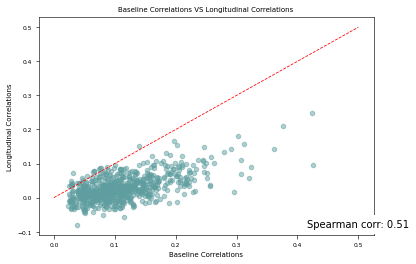

<Figure size 432x288 with 0 Axes>

In [124]:
%matplotlib inline

U, p = stats.spearmanr(sorted_results_df_2_years['training_set_scores'], sorted_results_df_2_years['Pearson Correlation'], alternative='two-sided')
to_plot = pd.concat([sorted_results_df_2_years['training_set_scores'], sorted_results_df_2_years['Pearson Correlation']] , axis=1)
to_plot.columns = ["Baseline Correlations", "Longitudinal Correlations"]
to_plot.plot.scatter("Baseline Correlations", "Longitudinal Correlations", color='cadetblue', alpha=0.5)
plt.title("Baseline Correlations VS Longitudinal Correlations")
plt.plot([0, 0.5], [0, 0.5], 'r--')
# plt.grid()
plt.text(0.5, plt.ylim()[0] + 0.05 * (plt.ylim()[1] - plt.ylim()[0]), f'Spearman corr: {U:.2f}', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='white'))
plt.savefig(home_path + f"figures/longitudinal/{SUBSET}/baseline_vs_logitudinal_corrs_" + TARGETS + ".png", dpi=400, facecolor="white", transparent=False, bbox_inches='tight')
plt.show()
plt.clf()

In [125]:
if TARGETS == 'abundance':
    def prints(sorted_results_df):
        # Total significants
        print("Total significants:", sorted_results_df['significant'].sum())
        # What percentage of significants?
        print("Percent of significants:", sorted_results_df['significant'].sum() / len(sorted_results_df))
        # Average prevalence of significant microbes baseline and 2nd visit
        print("Average prevalence of significant microbes in baseline:", sorted_results_df[sorted_results_df['significant'] == 1]['test_prevalence_baseline'].mean())
        print("Average prevalence of significant microbes in intervention:", sorted_results_df[sorted_results_df['significant'] == 1]['test_prevalence_visit'].mean())
        # Average prevalence of non-significant microbes baseline and 2nd visit
        print("Average prevalence of non-significant microbes in baseline:", sorted_results_df[sorted_results_df['significant'] == 0]['test_prevalence_baseline'].mean())
        print("Average prevalence of non-significant microbes in intervention:", sorted_results_df[sorted_results_df['significant'] == 0]['test_prevalence_visit'].mean())
        # Average prevalence in train data
        print("Average prevalence in 10k:", sorted_results_df['train_prevalence_baseline'].mean())
        # Average prevalence of non-significants in train data
        print("Average prevalence of non-significants in 10k:", sorted_results_df[sorted_results_df['significant'] == 0]['train_prevalence_baseline'].mean())

    prints(sorted_results_df_2_years)
    print()
    prints(sorted_results_df_4_years)

Total significants: 115
Percent of significants: 0.17319277108433734
Average prevalence of significant microbes in baseline: 742.9478260869565
Average prevalence of significant microbes in intervention: 740.1391304347826
Average prevalence of non-significant microbes in baseline: 441.4007285974499
Average prevalence of non-significant microbes in intervention: 438.9344262295082
Average prevalence in 10k: 2503.1927710843374
Average prevalence of non-significants in 10k: 2229.9216757741347

Total significants: 92
Percent of significants: 0.13855421686746988
Average prevalence of significant microbes in baseline: 787.2065217391304
Average prevalence of significant microbes in intervention: 637.75
Average prevalence of non-significant microbes in baseline: 446.40734265734267
Average prevalence of non-significant microbes in intervention: 363.9055944055944
Average prevalence in 10k: 2503.1927710843374
Average prevalence of non-significants in 10k: 2262.1486013986014


In [126]:
# # lgbm_div_perm_scores, lgbm_div_perm_pvalues = read_results(pd.read_pickle(home_path + "data/regression/lightGBM_output_diversity_perm.pkl"))
# lgbm_mircrobes_perm = pd.read_pickle(home_path + f"data/{PROBLEM}/{SPECIES}/output_LGBM_abundance_perm.pkl")
# microbes_perm_scores = lgbm_mircrobes_perm.loc[:, 0]
# # microbes_perm_pvalues = lgbm_mircrobes_perm.loc[:, 1]
# permutation_scores = microbes_perm_scores.iloc[:, :-4]
# percentile_99 = np.percentile(permutation_scores.values.flatten(), 99)

percentile_99 = 0.022 # DELETE AFTER WE HAVE PERMUTATIONS
percentile_99

0.022

In [127]:
sorted_results_df_2_years['significant']

fBin__541_gBin__2135_sBin__3290    1
fBin__187_gBin__748_sBin__1116     1
fBin__367_gBin__1458_sBin__2166    1
fBin__121_gBin__572_sBin__848      1
fBin__367_gBin__1456_sBin__2163    1
                                  ..
fBin__564_gBin__2174_sBin__3339    0
fBin__431_gBin__1689_sBin__2491    0
fBin__601_gBin__2279_sBin__3480    0
fBin__424_gBin__1678_sBin__2480    0
fBin__541_gBin__2057_sBin__3150    0
Name: significant, Length: 664, dtype: int64

In [128]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Define the bins for the histogram
# bins = np.linspace(sorted_results_df_2_years["Pearson Correlation"].min(), 
#                    sorted_results_df_2_years["Pearson Correlation"].max(), 
#                    21)  # 20 bins

# # Create the histogram for the full dataset
# hist, bin_edges = np.histogram(sorted_results_df_2_years["Pearson Correlation"], bins=bins)

# # Create the histogram for the significant values using a boolean mask
# significant_hist, _ = np.histogram(
#     sorted_results_df_2_years.loc[sorted_results_df_2_years["significant"].astype(bool), "Pearson Correlation"], 
#     bins=bins
# )

# # Plot the histogram
# plt.figure(figsize=(10, 5))
# plt.hist(sorted_results_df_2_years["Pearson Correlation"], bins=bins, edgecolor='black', 
#          color='cadetblue', alpha=1, label="All correlations")

# # Overlay the significant counts
# bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
# plt.bar(bin_centers, significant_hist, width=np.diff(bin_edges), edgecolor='black', 
#         color='black', alpha=0.5, label="Significant correlations")

# # Add labels and title
# plt.xlabel("Pearson's Correlation", fontsize=10)
# plt.ylabel("Frequency", fontsize=10)
# plt.title('Distribution of Correlations of Changes Across All Species', fontsize=12)
# plt.legend()

# # Save and show the figure
# plt.savefig(home_path + f"figures/longitudinal/{SUBSET}/longitudinal_correlations_with_significant_layer.png", 
#             dpi=400, facecolor="white", transparent=False, bbox_inches='tight')
# plt.show()

In [129]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Define the bins for the histogram
# bins = np.linspace(sorted_results_df_2_years["training_set_scores"].min(), 
#                    sorted_results_df_2_years["training_set_scores"].max(), 
#                    21)  # 20 bins

# # Create the histogram for the full dataset (2 years)
# hist, bin_edges = np.histogram(sorted_results_df_2_years["training_set_scores"], bins=bins)

# # Create the histogram for significant values (2 years)
# significant_hist_2y, _ = np.histogram(
#     sorted_results_df_2_years.loc[sorted_results_df_2_years["significant"].astype(bool), "training_set_scores"], 
#     bins=bins
# )

# # Create the histogram for significant values (4 years)
# significant_hist_4y, _ = np.histogram(
#     sorted_results_df_4_years.loc[sorted_results_df_4_years["significant"].astype(bool), "training_set_scores"], 
#     bins=bins
# )

# # Plot the histogram
# plt.figure(figsize=(10, 5))
# plt.hist(sorted_results_df_2_years["training_set_scores"], bins=bins, edgecolor='black', 
#          color='cadetblue', alpha=1, label="Cross-validated correlations")

# # Overlay the 2-year significant counts
# bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
# plt.bar(bin_centers, significant_hist_2y, width=np.diff(bin_edges), edgecolor='black', 
#         color='black', alpha=0.5, label="Significants in longitudinal (2y)")

# # Overlay the 4-year significant counts
# plt.bar(bin_centers, significant_hist_4y, width=np.diff(bin_edges), edgecolor='black', 
#         color='green', alpha=0.5, label="Significants in longitudinal (4y)")

# # Add reference line
# plt.axvline(percentile_99, color='red', linestyle='dotted', linewidth=2, label="99th percentile of permutations")

# # Add labels and title
# plt.xlabel("Pearson's Correlation", fontsize=10)
# plt.ylabel("Frequency", fontsize=10)
# # plt.title('Distribution of Correlations of Changes Across All Species', fontsize=12)
# plt.legend()

# # Save and show the figure
# # plt.savefig(home_path + f"figures/longitudinal/{SUBSET}/longitudinal_original_correlations_with_significant_layer.png", 
# #             dpi=400, facecolor="white", transparent=False, bbox_inches='tight')
# plt.show()


In [130]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Assume sorted_results_df_2_years and sorted_results_df_4_years are pre-existing DataFrames

# # (Calculations for all histograms remain the same as your original code)
# # hist, bin_edges, significant_hist_2y, significant_hist_4y
# # bin_centers

# # --- Define Bins and Calculate Histograms ---
# # (This part of the code is unchanged)
# bins = np.linspace(
#     sorted_results_df_2_years["Pearson Correlation"].min(),
#     sorted_results_df_2_years["Pearson Correlation"].max(),
#     21
# )
# hist_all_2y, bin_edges = np.histogram(sorted_results_df_2_years["Pearson Correlation"], bins=bins)
# significant_hist_2y, _ = np.histogram(sorted_results_df_2_years.loc[sorted_results_df_2_years["significant"].astype(bool), "Pearson Correlation"], bins=bins)
# hist_all_4y, _ = np.histogram(sorted_results_df_4_years["Pearson Correlation"], bins=bins)
# significant_hist_4y, _ = np.histogram(sorted_results_df_4_years.loc[sorted_results_df_4_years["significant"].astype(bool), "Pearson Correlation"], bins=bins)
# bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])


# # --- Create the Plots ---
# # Create two subplots that share the same x-axis
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
# # fig.suptitle('Comparison of Correlation Distributions', fontsize=16)

# # --- Plot 1: 2-Year Data (Unchanged) ---
# ax1.hist(sorted_results_df_2_years["Pearson Correlation"], bins=bins, edgecolor='black', color='cadetblue', alpha=0.8, label="All correlations (2y)")
# ax1.plot(bin_centers, significant_hist_2y, label="Significants (2y)", color='black', marker='o')
# ax1.set_ylabel("Frequency")
# ax1.legend()
# ax1.set_title("2-Year Follow-up")

# # --- Plot 2: 4-Year Data (New Colors) ---
# # We now plot the histogram for the 4-year data as the reference
# ax2.hist(sorted_results_df_4_years["Pearson Correlation"], bins=bins, edgecolor='black', color='coral', alpha=0.8, label="All correlations (4y)")
# ax2.plot(bin_centers, significant_hist_4y, label="Significants (4y)", color='black', marker='o')
# ax2.set_xlabel("Pearson's Correlation")
# ax2.set_ylabel("Frequency")
# ax2.legend()
# ax2.set_title("4-Year Follow-up")

# plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
# plt.show()

In [131]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Assume sorted_results_df_2_years and sorted_results_df_4_years are pre-existing DataFrames

# # --- Define Bins and Calculate Histograms ---
# # (This part of the code is unchanged from before)
# bins = np.linspace(
#     sorted_results_df_2_years["Pearson Correlation"].min(),
#     sorted_results_df_2_years["Pearson Correlation"].max(),
#     21
# )
# significant_hist_2y, bin_edges = np.histogram(
#     sorted_results_df_2_years.loc[sorted_results_df_2_years["significant"].astype(bool), "Pearson Correlation"],
#     bins=bins
# )
# significant_hist_4y, _ = np.histogram(
#     sorted_results_df_4_years.loc[sorted_results_df_4_years["significant"].astype(bool), "Pearson Correlation"],
#     bins=bins
# )
# bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])


# # --- Create the Combined Plot ---
# plt.style.use('default')

# plt.figure(figsize=(10, 6))

# color_2y = '#0077b6' # A clear, strong blue
# color_4y = '#d9534f' # A contrasting soft red

# # Plot the 2-year histogram with transparency
# plt.hist(sorted_results_df_2_years["Pearson Correlation"],
#          bins=bins,
#          edgecolor='dimgray',
#          color=color_2y,
#          alpha=0.5,  # Key parameter for transparency
#          label="All correlations (2y)")

# # Plot the 4-year histogram with transparency
# plt.hist(sorted_results_df_4_years["Pearson Correlation"],
#          bins=bins,
#          edgecolor='dimgray',
#          color=color_4y,
#          alpha=0.5, # Key parameter for transparency
#          label="All correlations (4y)")


# plt.plot(bin_centers, significant_hist_2y, label="Significants (2y)", color=color_2y,
#         marker='o', markersize=6, linewidth=2.5, zorder=3)
# plt.plot(bin_centers, significant_hist_4y, label="Significants (4y)", color=color_4y,
#         marker='o', markersize=6, linewidth=2.5, zorder=3)

# # Add labels and title
# plt.xlabel("Pearson's Correlation", fontsize=12)
# plt.ylabel("Frequency", fontsize=12)
# # plt.title("Comparison of 2-Year and 4-Year Correlation Distributions", fontsize=14)
# plt.legend()
# plt.tight_layout()
# plt.savefig(home_path + f"figures/longitudinal/{SUBSET}/longitudinal_correlations_with_significant_layer.png", 
#             dpi=400, facecolor="white", transparent=False, bbox_inches='tight')
# plt.savefig(home_path + f"figures/longitudinal/{SUBSET}/longitudinal_correlations_with_significant_layer.pdf", 
#             dpi=400, facecolor="white", transparent=False, bbox_inches='tight', format='pdf')

# plt.show()

In [132]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Assume sorted_results_df_2_years and sorted_results_df_4_years are pre-existing DataFrames

# # --- 1. Define Bins with a fixed size of 0.05 ---
# # Find the overall min and max correlation across BOTH datasets to create a common range
# min_corr = min(sorted_results_df_2_years["Pearson Correlation"].min(), sorted_results_df_4_years["Pearson Correlation"].min())
# max_corr = max(sorted_results_df_2_years["Pearson Correlation"].max(), sorted_results_df_4_years["Pearson Correlation"].max())

# # Create bins of size 0.05 spanning the entire data range
# bins = np.arange(min_corr, max_corr + 0.05, 0.05)

# # --- 2. Calculate Histogram Counts for Percentage Calculation ---
# # --- 2-Year Data ---
# hist_all_2y, bin_edges = np.histogram(sorted_results_df_2_years["Pearson Correlation"], bins=bins)
# significant_hist_2y, _ = np.histogram(
#     sorted_results_df_2_years.loc[sorted_results_df_2_years["significant"].astype(bool), "Pearson Correlation"],
#     bins=bins
# )

# # --- 4-Year Data ---
# hist_all_4y, _ = np.histogram(sorted_results_df_4_years["Pearson Correlation"], bins=bins)
# significant_hist_4y, _ = np.histogram(
#     sorted_results_df_4_years.loc[sorted_results_df_4_years["significant"].astype(bool), "Pearson Correlation"],
#     bins=bins
# )

# # --- 3. Calculate Percentages ---
# # Safely calculate the percentage of significant correlations in each bin
# percentage_2y = np.divide(significant_hist_2y, hist_all_2y, out=np.zeros_like(significant_hist_2y, dtype=float), where=hist_all_2y != 0) * 100
# percentage_4y = np.divide(significant_hist_4y, hist_all_4y, out=np.zeros_like(significant_hist_4y, dtype=float), where=hist_all_4y != 0) * 100

# # Get the center of each bin for the x-axis coordinates
# bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# # --- 4. Create the Final Line Plot ---
# plt.figure(figsize=(12, 7))

# # Plot the percentage lines
# plt.plot(bin_centers, percentage_2y, label="Significant % (2y)", color='cadetblue', marker='o', linestyle='-')
# plt.plot(bin_centers, percentage_4y, label="Significant % (4y)", color='coral', marker='o', linestyle='-')

# # --- 5. Add Labels, Title, and Final Touches ---
# plt.xlabel("Pearson's Correlation Bins", fontsize=12)
# plt.ylabel("Significant Correlations (%)", fontsize=12)
# plt.title("Rate of Significant Correlations", fontsize=14)

# # Set the y-axis to be from 0 to 100
# plt.ylim(0, 100)
# # Add a grid for easier reading of values
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# plt.legend()
# plt.tight_layout()

# plt.show()

In [133]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Define the bins for the histogram
# bins = np.linspace(sorted_results_df_2_years["training_set_scores"].min(), 
#                    sorted_results_df_2_years["training_set_scores"].max(), 
#                    21)  # 20 bins

# # Create the histogram for the full dataset (2 years)
# hist, bin_edges = np.histogram(sorted_results_df_2_years["training_set_scores"], bins=bins)

# # Create the histogram for significant values (2 years)
# significant_hist_2y, _ = np.histogram(
#     sorted_results_df_2_years.loc[sorted_results_df_2_years["significant"].astype(bool), "training_set_scores"], 
#     bins=bins
# )

# # Create the histogram for significant values (4 years)
# significant_hist_4y, _ = np.histogram(
#     sorted_results_df_4_years.loc[sorted_results_df_4_years["significant"].astype(bool), "training_set_scores"], 
#     bins=bins
# )

# plt.figure(figsize=(10, 5))
# bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
# plt.hist(sorted_results_df_2_years["training_set_scores"], bins=bins, edgecolor='black', 
#          color='cadetblue', alpha=0.8, label="Cross-validated correlations")

# plt.plot(bin_centers, significant_hist_2y, label="Significants (2y)", color='black', marker='o')
# plt.plot(bin_centers, significant_hist_4y, label="Significants (4y)", color='mediumvioletred', marker='o')

# plt.axvline(percentile_99, color='red', linestyle='dotted', linewidth=2, label="99th percentile of permutations")
# plt.xlabel("Pearson's Correlation")
# plt.ylabel("Frequency")
# plt.legend()
# plt.tight_layout()

# # Save and show the figure
# plt.savefig(home_path + f"figures/longitudinal/{SUBSET}/longitudinal_original_correlations_with_significant_layer.png", 
#             dpi=400, facecolor="white", transparent=False, bbox_inches='tight')


Correlations of changes individual changes visualization

In [134]:
delta_measured.mean()

fBin__100_gBin__473_sBin__693   -0.013522
fBin__100_gBin__473_sBin__694    0.018257
fBin__100_gBin__477_sBin__698   -0.009483
fBin__100_gBin__481_sBin__704    0.015229
fBin__100_gBin__481_sBin__705    0.024401
                                   ...   
fBin__95_gBin__450_sBin__659     0.023702
fBin__96_gBin__457_sBin__669    -0.016807
fBin__97_gBin__462_sBin__676     0.029206
fBin__97_gBin__462_sBin__678    -0.000679
fBin__99_gBin__469_sBin__687     0.008182
Length: 664, dtype: float64

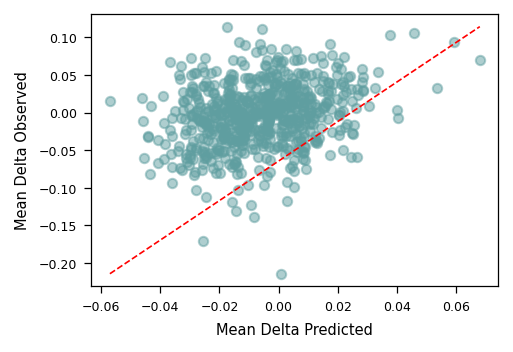

<Figure size 525x360 with 0 Axes>

In [135]:
style = "nature_single.mplstyle"
plt.rcParams["figure.dpi"] = 150

plt.style.use(style)


to_plot = pd.concat([delta_predicted.mean(), delta_measured.mean()] , axis=1)
to_plot.columns = ["Mean Delta Predicted", "Mean Delta Observed"]
to_plot.plot.scatter("Mean Delta Predicted", "Mean Delta Observed", color='cadetblue', alpha=0.5)
# plt.title("Cross-validated correlations VS Predicted baseline correlations")
plt.plot([delta_predicted.mean().min(),delta_predicted.mean().max()], [delta_measured.mean().min(),delta_measured.mean().max()], 'r--')
# plt.grid()
# plt.text(0.25, plt.ylim()[0] + 0.06 * (plt.ylim()[1] - plt.ylim()[0]), rf'$R^2 = {r2_baseline:.2f}$', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='white'))
# plt.savefig(home_path + f"figures/longitudinal/{SUBSET}/predicted_VS_observed_changes" + TARGETS + ".png", dpi=400, facecolor="white", transparent=False, bbox_inches='tight')
# plt.savefig(home_path + f"figures/longitudinal/{SUBSET}/predicted_VS_observed_changes" + TARGETS + ".pdf", dpi=400, facecolor="white", transparent=False, bbox_inches='tight', format='pdf')
plt.show()
plt.clf()

Pearson r = 0.27, p = 2.09e-12


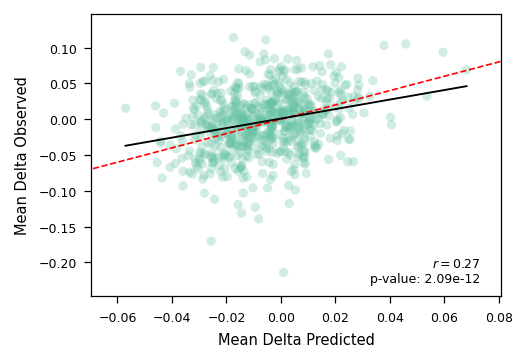

<Figure size 525x360 with 0 Axes>

In [197]:
import numpy as np
from scipy.stats import linregress

style = "nature_single.mplstyle"
plt.rcParams["figure.dpi"] = 150
plt.style.use(style)

# Build the scatter data
to_plot = pd.concat([delta_predicted.mean(), delta_measured.mean()], axis=1)
to_plot.columns = ["Mean Delta Predicted", "Mean Delta Observed"]

# Get x, y and drop any NaNs/Infs
x = to_plot["Mean Delta Predicted"].to_numpy()
y = to_plot["Mean Delta Observed"].to_numpy()
m = np.isfinite(x) & np.isfinite(y)
x, y = x[m], y[m]

# Scatter
ax = to_plot.plot.scatter("Mean Delta Predicted", "Mean Delta Observed",
                          color=color1, alpha=0.3, edgecolor='none')


# Compute padding factors
x_pad = 0.1 * (x.max() - x.min())
y_pad = 0.1 * (y.max() - y.min())

# Apply limits with padding
ax.set_xlim(x.min() - x_pad, x.max() + x_pad)
ax.set_ylim(y.min() - y_pad, y.max() + y_pad)

# Recompute y=x line to span the new limits
xy_min = min(ax.get_xlim()[0], ax.get_ylim()[0])
xy_max = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.plot([xy_min, xy_max], [xy_min, xy_max], "r--", linewidth=0.8, label="y = x")


# # y = x reference
# xy_min = np.nanmin([x.min(), y.min()])
# xy_max = np.nanmax([x.max(), y.max()])
# # ax.plot([xy_min, xy_max], [xy_min, xy_max], "r--", linewidth=0.8, label="y = x")
# ax.plot([xy_min, xy_max], [xy_min, xy_max], "r--", linewidth=0.8, label="y = x")

# OLS fit line
slope, intercept, r, p, se = linregress(x, y)
x_line = np.linspace(x.min(), x.max(), 200)
ax.plot(x_line, intercept + slope * x_line, "-", linewidth=0.9, color="k",
        label=fr"fit: y = {slope:.2f}x + {intercept:.2f}  (R$^2$ = {r**2:.2f})")


# Pearson r for the scatter
r, p = pearsonr(x, y)
print(f"Pearson r = {r:.2f}, p = {p:.2e}")

# Place annotation near the top-left inside the axes
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.text(
    x1 - 0.05 * (x1 - x0),
    y0 + 0.04 * (y1 - y0),
    rf"$r = {r:.2f}$" + f"\np-value: {p:.2e}",
    ha="right", va="bottom",
    bbox=dict(facecolor="white", edgecolor="white")
)

plt.tight_layout()
# ax.legend(frameon=False)
plt.savefig(home_path + f"figures/longitudinal/{SUBSET}/predicted_VS_observed_changes" + TARGETS + ".png", dpi=400, facecolor="white", transparent=False)
plt.savefig(home_path + f"figures/longitudinal/{SUBSET}/predicted_VS_observed_changes" + TARGETS + ".pdf", dpi=400, facecolor="white", transparent=False, format='pdf')
plt.show()
plt.clf()

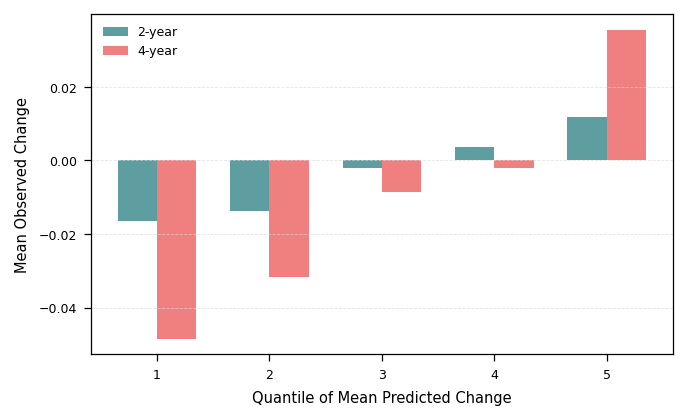

<Figure size 525x360 with 0 Axes>

In [137]:
import numpy as np

# 1. Calculate the mean change per microbe for 2-yr and 4-yr
mean_pred_2y = delta_predicted.mean(axis=0)
mean_act_2y = delta_measured.mean(axis=0)

mean_pred_4y = delta_predicted_4_years.mean(axis=0)
mean_act_4y = delta_measured_4_years.mean(axis=0)

# 2. Build DataFrames
df2 = pd.DataFrame({
    'predicted_change': mean_pred_2y,
    'actual_change':    mean_act_2y
})

df4 = pd.DataFrame({
    'predicted_change': mean_pred_4y,
    'actual_change':    mean_act_4y
})

# 3. Number of quantiles
num_quantiles = 5

# 4. Assign each microbe to a quintile based on its predicted change
df2['quantile'] = pd.qcut(df2['predicted_change'], num_quantiles, labels=False, duplicates='drop')
df4['quantile'] = pd.qcut(df4['predicted_change'], num_quantiles, labels=False, duplicates='drop')

# 5. Compute the average actual change in each quintile
quant2 = df2.groupby('quantile')['actual_change'].mean().reset_index()
quant4 = df4.groupby('quantile')['actual_change'].mean().reset_index()

# 6. Plot side-by-side bars
x = np.arange(num_quantiles)
width = 0.35

plt.figure(figsize=(5, 3))
plt.bar(x - width/2, quant2['actual_change'], width, label='2-year', color='cadetblue')
plt.bar(x + width/2, quant4['actual_change'], width, label='4-year', color='lightcoral')

plt.xlabel('Quantile of Mean Predicted Change')
plt.ylabel('Mean Observed Change')
plt.xticks(x, range(1, num_quantiles + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# 7. Save & show
plt.savefig(home_path + f"figures/longitudinal/{SUBSET}/correlations_of_changes_quantiles.png",
            dpi=400, facecolor="white", transparent=False, bbox_inches='tight')
plt.savefig(home_path + f"figures/longitudinal/{SUBSET}/correlations_of_changes_quantiles.pdf",
            dpi=400, facecolor="white", transparent=False, bbox_inches='tight', format='pdf')
plt.show()
plt.clf()


### Plot histograms

In [138]:
combined_df = pd.concat(
    [
        predicted_baseline_df.assign(research_stage='baseline').set_index('research_stage', append=True),
        predicted_02_visit_df.assign(research_stage='02_visit').set_index('research_stage', append=True)
    ]
)
combined_df

,,fBin__100_gBin__473_sBin__693,fBin__100_gBin__473_sBin__694,fBin__100_gBin__477_sBin__698,fBin__100_gBin__481_sBin__704,fBin__100_gBin__481_sBin__705,fBin__100_gBin__481_sBin__706,fBin__100_gBin__483_sBin__709,fBin__102_gBin__490_sBin__721,fBin__102_gBin__490_sBin__722,fBin__103_gBin__491_sBin__727,...,fBin__86_gBin__423_sBin__620,fBin__86_gBin__429_sBin__631,fBin__88_gBin__434_sBin__637,fBin__94_gBin__448_sBin__654,fBin__94_gBin__449_sBin__656,fBin__95_gBin__450_sBin__659,fBin__96_gBin__457_sBin__669,fBin__97_gBin__462_sBin__676,fBin__97_gBin__462_sBin__678,fBin__99_gBin__469_sBin__687
RegistrationCode,research_stage,,,,,,,,,,,,,,,,,,,,,
10K_1001201093,baseline,0.089290,-0.057263,0.001791,-0.032566,0.091337,-0.030401,-0.025307,0.019080,0.020364,0.016668,...,0.082972,-0.155681,0.003138,-0.128740,-0.043756,0.052975,-0.045067,-0.015359,-0.072039,-0.002750
10K_1002254441,baseline,0.097553,0.085448,-0.032439,0.044498,0.051633,-0.033473,0.150439,0.074200,-0.060200,0.057110,...,-0.044499,0.157518,-0.102299,0.392225,0.144698,-0.053079,0.148657,0.012109,0.179546,-0.040393
10K_1007400622,baseline,0.046244,0.029975,-0.140298,-0.025992,-0.007889,0.021600,0.025346,0.044896,0.006517,0.022249,...,0.046199,0.244688,0.156984,-0.063588,-0.021717,-0.018285,0.059159,0.045501,0.025634,0.028208
10K_1008294272,baseline,-0.019092,-0.027828,0.072528,-0.033487,0.012470,0.001325,0.005712,-0.041349,-0.085609,0.044268,...,-0.102082,0.096820,-0.116355,0.149896,-0.002462,0.007120,-0.054262,-0.047536,-0.062101,-0.031233
10K_1009247427,baseline,0.026044,-0.059591,-0.084608,0.028909,-0.064781,0.082021,-0.019083,0.116898,0.063276,0.015677,...,0.056678,-0.048526,0.066705,-0.021456,-0.031800,-0.064473,0.016196,0.026933,0.048214,-0.084557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10K_9949511818,02_visit,0.036616,-0.033475,-0.061880,-0.042359,-0.031238,-0.056298,0.006086,-0.032258,-0.050932,-0.005971,...,0.056695,0.158838,0.102296,-0.133537,-0.062757,-0.011467,0.000395,0.086647,0.023257,0.026794
10K_9952952835,02_visit,-0.076474,-0.079207,-0.001385,-0.006463,-0.013564,0.031970,-0.136621,0.159411,0.035966,-0.043732,...,0.073049,-0.215962,-0.093906,0.166584,0.004687,0.054773,-0.089088,-0.066952,0.018440,-0.076591
10K_9953095892,02_visit,0.114689,0.184927,-0.076944,-0.044876,-0.053219,-0.083111,0.229120,0.080526,-0.048506,0.136778,...,0.005030,0.220847,0.002138,0.211688,0.000743,0.005041,0.106143,0.111935,0.126652,-0.140716


In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

def plot_correlation_histograms(data_df,
                                reg_code_level_name="RegistrationCode",
                                research_stage_level_name="research_stage",
                                min_corr_periods=1,
                                num_other_people_sample=10,
                                bins=20,
                                figure_title="Distribution of Spearman Correlations",
                                dataset_name=""):
    """
    Generates and displays overlaid histograms of self-to-self (different visit)
    correlations and self-to-other (mean of N others) correlations.

    Args:
        data_df (pd.DataFrame): Input DataFrame with a MultiIndex (reg_code, research_stage).
        reg_code_level_name (str): Name of the RegistrationCode index level.
        research_stage_level_name (str): Name of the research_stage index level.
        min_corr_periods (int): Minimum periods for pandas .corr() method.
        num_other_people_sample (int): Number of other people to sample for self-to-other calculation.
        bins (int or sequence): Number of bins for the histograms.
        figure_title (str): Title for the plot.
        dataset_name (str): Optional name for the dataset to include in labels/title.

    Returns:
        tuple: (fig, ax) handles for the matplotlib figure and axes.
               Returns (None, None) if data processing fails.
    """

    print(f"Processing dataset: {dataset_name if dataset_name else 'Unnamed'}")

    # --- 1. Calculate Spearman Correlation Matrix (Visit-Level) ---
    data_transposed = data_df.T
    try:
        # Ensure index names of transposed df are set for proper MultiIndex in corr_matrix
        data_transposed.columns.names = [reg_code_level_name, research_stage_level_name]
        corr_matrix = data_transposed.corr(method='spearman', min_periods=min_corr_periods)
    except Exception as e:
        print(f"Error during correlation calculation: {e}")
        return None, None

    np.fill_diagonal(corr_matrix.values, np.nan) # Exclude self-correlation at same stage

    if corr_matrix.empty:
        print("Correlation matrix is empty. Cannot proceed.")
        return None, None

    # Get unique registration codes and research stages present in the correlation matrix
    # This ensures we only work with codes/stages that actually produced correlation values
    valid_indices = corr_matrix.index
    unique_reg_codes = valid_indices.get_level_values(reg_code_level_name).unique()

    # --- 2. Calculate Self-to-Self (Different Visit) Correlations ---
    self_to_self_correlations = []
    for reg_code in unique_reg_codes:
        # Find the specific visits (stages) for this reg_code from the corr_matrix index
        person_visits_indices = [idx for idx in valid_indices if idx[0] == reg_code]

        if len(person_visits_indices) == 2: # Expecting two visits
            visit1_idx = person_visits_indices[0]
            visit2_idx = person_visits_indices[1]
            # Ensure both indices exist in the matrix (should be true if from valid_indices)
            if visit1_idx in corr_matrix.index and visit2_idx in corr_matrix.columns:
                correlation = corr_matrix.loc[visit1_idx, visit2_idx]
                if pd.notna(correlation):
                    self_to_self_correlations.append(correlation)
            # else: # Should not happen if logic is correct
            #     print(f"Warning: Could not find visit correlation for {reg_code} between {visit1_idx} and {visit2_idx}")
        # elif len(person_visits_indices) == 1:
            # print(f"Note: {reg_code} has only one visit in the correlation matrix. Skipping self-to-self.")
        # else:
            # print(f"Note: {reg_code} has {len(person_visits_indices)} visits. Expected 2 for self-to-self. Skipping.")


    # --- 3. Calculate Self-to-Other (Mean of N Others) Correlations ---
    self_to_other_mean_correlations = []
    all_available_reg_codes = list(unique_reg_codes)

    for current_reg_code in unique_reg_codes:
        other_reg_codes = [rc for rc in all_available_reg_codes if rc != current_reg_code]

        if not other_reg_codes:
            # print(f"Note: No other people available for {current_reg_code} to compare against. Skipping.")
            continue

        if len(other_reg_codes) > num_other_people_sample:
            sampled_other_codes = random.sample(other_reg_codes, num_other_people_sample)
        else:
            sampled_other_codes = other_reg_codes # Use all if fewer than N

        current_person_visits_indices = [idx for idx in valid_indices if idx[0] == current_reg_code]
        if not current_person_visits_indices: # Should not happen if current_reg_code from unique_reg_codes
            continue

        corrs_to_sampled_others_means = [] # For this current_reg_code, avg corr to each sampled_other_code
        for other_code in sampled_other_codes:
            other_person_visits_indices = [idx for idx in valid_indices if idx[0] == other_code]
            if not other_person_visits_indices: # Should not happen
                continue

            cross_visit_corrs_for_this_pair = []
            for pv_idx in current_person_visits_indices:
                for ov_idx in other_person_visits_indices:
                    # Ensure indices are in the matrix before attempting .loc
                    if pv_idx in corr_matrix.index and ov_idx in corr_matrix.columns:
                        correlation = corr_matrix.loc[pv_idx, ov_idx]
                        if pd.notna(correlation):
                            cross_visit_corrs_for_this_pair.append(correlation)
            
            if cross_visit_corrs_for_this_pair:
                mean_corr_to_this_other_person = np.mean(cross_visit_corrs_for_this_pair)
                corrs_to_sampled_others_means.append(mean_corr_to_this_other_person)

        if corrs_to_sampled_others_means: # If any valid mean correlations to other people were found
            overall_mean_to_others = np.mean(corrs_to_sampled_others_means)
            self_to_other_mean_correlations.append(overall_mean_to_others)

    # --- 4. Plotting ---
    if not self_to_self_correlations and not self_to_other_mean_correlations:
        print("No correlation data available to plot histograms.")
        return None, None

    fig, ax = plt.subplots(figsize=(12, 7))

    plot_title = figure_title
    if dataset_name:
        plot_title += f" ({dataset_name})"
    ax.set_title(plot_title)
    ax.set_xlabel("Spearman Correlation Coefficient")
    ax.set_ylabel("Frequency" if not (len(self_to_self_correlations) > 0 and len(self_to_other_mean_correlations) > 0 and plt.gca().get_ylabel() == 'Density') else "Density")


    if self_to_self_correlations:
        ax.hist(self_to_self_correlations, bins=bins, alpha=0.7, label=f'Self-to-Self (Other Visit)\n(N={len(self_to_self_correlations)})', density=True)
        print(f"Self-to-Self: N={len(self_to_self_correlations)}, Mean={np.mean(self_to_self_correlations):.3f}, Std={np.std(self_to_self_correlations):.3f}")


    if self_to_other_mean_correlations:
        ax.hist(self_to_other_mean_correlations, bins=bins, alpha=0.7, label=f'Self-to-Other (Mean of ~{num_other_people_sample} Others)\n(N={len(self_to_other_mean_correlations)})', density=True)
        print(f"Self-to-Other: N={len(self_to_other_mean_correlations)}, Mean={np.mean(self_to_other_mean_correlations):.3f}, Std={np.std(self_to_other_mean_correlations):.3f}")

    if self_to_self_correlations or self_to_other_mean_correlations:
        ax.legend(loc='best')
        ax.grid(axis='y', alpha=0.75)
    else: # Should be caught earlier, but as a fallback
        ax.text(0.5, 0.5, "No data to display", ha='center', va='center', transform=ax.transAxes)


    plt.tight_layout()
    return fig, ax


predicted VS predicted

In [140]:
# fig1, ax1 = plot_correlation_histograms(
#     combined_df,
#     reg_code_level_name="RegistrationCode",
#     research_stage_level_name="research_stage",
#     min_corr_periods=5, # Using 5 for slightly more robustness with random data
#     num_other_people_sample=10, # Using 3 for faster test with small N of people
#     bins=45,
#     dataset_name="Longitudinal"
# )
# if fig1:
#     plt.show()

measured VS predicted

In [141]:
# combined_df = pd.concat(
#     [
#         measured_baseline[significant_targets].assign(research_stage='baseline_measured').set_index('research_stage', append=True),
#         predicted_baseline_df[significant_targets].assign(research_stage='baseline_pred').set_index('research_stage', append=True)
#     ]
# )

# fig1, ax1 = plot_correlation_histograms(
#     combined_df,
#     reg_code_level_name="RegistrationCode",
#     research_stage_level_name="research_stage",
#     min_corr_periods=5, # Using 5 for slightly more robustness with random data
#     num_other_people_sample=10, # Using 3 for faster test with small N of people
#     bins=45,
#     dataset_name="Longitudinal"
# )
# if fig1:
#     plt.show()

In [142]:
# combined_df = pd.concat(
#     [
#         measured_02_visit[significant_targets].assign(research_stage='02_visit_measured').set_index('research_stage', append=True),
#         predicted_02_visit_df[significant_targets].assign(research_stage='02_visit_pred').set_index('research_stage', append=True)
#     ]
# )

# fig1, ax1 = plot_correlation_histograms(
#     combined_df,
#     reg_code_level_name="RegistrationCode",
#     research_stage_level_name="research_stage",
#     min_corr_periods=5, # Using 5 for slightly more robustness with random data
#     num_other_people_sample=10, # Using 3 for faster test with small N of people
#     bins=45,
#     dataset_name="Longitudinal"
# )
# if fig1:
#     plt.show()

In [143]:
# combined_df = pd.concat(
#     [
#         measured_04_visit[significant_targets].assign(research_stage='04_visit_measured').set_index('research_stage', append=True),
#         predicted_04_visit_df[significant_targets].assign(research_stage='04_visit_pred').set_index('research_stage', append=True)
#     ]
# )

# fig1, ax1 = plot_correlation_histograms(
#     combined_df,
#     reg_code_level_name="RegistrationCode",
#     research_stage_level_name="research_stage",
#     min_corr_periods=5, # Using 5 for slightly more robustness with random data
#     num_other_people_sample=10, # Using 3 for faster test with small N of people
#     bins=45,
#     dataset_name="Longitudinal"
# )
# if fig1:
#     plt.show()

Baseline diet vs other stages

In [144]:
# combined_df = pd.concat(
#     [
#         measured_baseline[all_features].assign(research_stage='baseline_measured').set_index('research_stage', append=True),
#         measured_02_visit[all_features].assign(research_stage='02_visit_measured').set_index('research_stage', append=True)
#     ]
# )

# fig1, ax1 = plot_correlation_histograms(
#     combined_df,
#     reg_code_level_name="RegistrationCode",
#     research_stage_level_name="research_stage",
#     min_corr_periods=5, # Using 5 for slightly more robustness with random data
#     num_other_people_sample=10, # Using 3 for faster test with small N of people
#     bins=45,
#     dataset_name="Longitudinal"
# )
# if fig1:
#     plt.show()

In [145]:
# def plot_correlation_histograms(data_df,
#                                 reg_code_level_name="RegistrationCode",
#                                 research_stage_level_name="research_stage",
#                                 min_corr_periods=1,
#                                 num_other_people_sample=10,
#                                 bins=20,
#                                 figure_title="Distribution of Spearman Correlations",
#                                 dataset_name=""):
#     print(f"Processing dataset: {dataset_name if dataset_name else 'Unnamed'}")

#     data_transposed = data_df.T
#     try:
#         data_transposed.columns.names = [reg_code_level_name, research_stage_level_name]
#         corr_matrix = data_transposed.corr(method='spearman', min_periods=min_corr_periods)
#     except Exception as e:
#         print(f"Error during correlation calculation: {e}")
#         return None, None

#     np.fill_diagonal(corr_matrix.values, np.nan)
#     if corr_matrix.empty:
#         print("Correlation matrix is empty. Cannot proceed.")
#         return None, None

#     valid_indices = corr_matrix.index
#     unique_reg_codes = valid_indices.get_level_values(reg_code_level_name).unique()

#     # --- Self-to-Self Correlations (2y and 4y) ---
#     self_to_self_2y = []
#     self_to_self_4y = []

#     for reg_code in unique_reg_codes:
#         person_visits_indices = [idx for idx in valid_indices if idx[0] == reg_code]

#         # Sort visit labels to ensure consistent ordering (baseline before 02 before 04)
#         person_visits_indices.sort(key=lambda x: x[1])

#         if len(person_visits_indices) >= 2:
#             visit1_idx = person_visits_indices[0]
#             visit2_idx = person_visits_indices[1]
#             if visit1_idx in corr_matrix.index and visit2_idx in corr_matrix.columns:
#                 correlation = corr_matrix.loc[visit1_idx, visit2_idx]
#                 if pd.notna(correlation):
#                     self_to_self_2y.append(correlation)

#         if len(person_visits_indices) >= 3:
#             visit1_idx = person_visits_indices[0]
#             visit3_idx = person_visits_indices[2]
#             if visit1_idx in corr_matrix.index and visit3_idx in corr_matrix.columns:
#                 correlation = corr_matrix.loc[visit1_idx, visit3_idx]
#                 if pd.notna(correlation):
#                     self_to_self_4y.append(correlation)

#     # --- Self-to-Other Correlations ---
#     self_to_other_mean_correlations = []
#     all_available_reg_codes = list(unique_reg_codes)

#     for current_reg_code in unique_reg_codes:
#         other_reg_codes = [rc for rc in all_available_reg_codes if rc != current_reg_code]
#         if not other_reg_codes:
#             continue

#         sampled_other_codes = random.sample(other_reg_codes, num_other_people_sample) \
#                               if len(other_reg_codes) > num_other_people_sample else other_reg_codes

#         current_person_visits_indices = [idx for idx in valid_indices if idx[0] == current_reg_code]
#         if not current_person_visits_indices:
#             continue

#         corrs_to_sampled_others_means = []
#         for other_code in sampled_other_codes:
#             other_person_visits_indices = [idx for idx in valid_indices if idx[0] == other_code]
#             if not other_person_visits_indices:
#                 continue

#             cross_visit_corrs_for_this_pair = []
#             for pv_idx in current_person_visits_indices:
#                 for ov_idx in other_person_visits_indices:
#                     if pv_idx in corr_matrix.index and ov_idx in corr_matrix.columns:
#                         correlation = corr_matrix.loc[pv_idx, ov_idx]
#                         if pd.notna(correlation):
#                             cross_visit_corrs_for_this_pair.append(correlation)

#             if cross_visit_corrs_for_this_pair:
#                 mean_corr_to_this_other_person = np.mean(cross_visit_corrs_for_this_pair)
#                 corrs_to_sampled_others_means.append(mean_corr_to_this_other_person)

#         if corrs_to_sampled_others_means:
#             overall_mean_to_others = np.mean(corrs_to_sampled_others_means)
#             self_to_other_mean_correlations.append(overall_mean_to_others)

#     # --- Plotting ---
#     if not self_to_self_2y and not self_to_other_mean_correlations and not self_to_self_4y:
#         print("No correlation data available to plot histograms.")
#         return None, None

#     fig, ax = plt.subplots(figsize=(6, 3.5))
#     plot_title = figure_title + (f" ({dataset_name})" if dataset_name else "")
#     # ax.set_title(plot_title)
#     ax.set_xlabel("Spearman Correlation Coefficient")
#     ax.set_ylabel("Density")

#     if self_to_self_2y:
#         ax.hist(self_to_self_2y, bins=bins, alpha=0.5, label=f'Self-to-Self (2 Year Visit)\n(N={len(self_to_self_2y)})', density=True)
#         print(f"Self-to-Self (2y): N={len(self_to_self_2y)}, Mean={np.mean(self_to_self_2y):.3f}, Std={np.std(self_to_self_2y):.3f}")

#     if self_to_self_4y:
#         ax.hist(self_to_self_4y, bins=bins, alpha=0.5, label=f'Self-to-Self (4 Year Visit)\n(N={len(self_to_self_4y)})', density=True)
#         print(f"Self-to-Self (4y): N={len(self_to_self_4y)}, Mean={np.mean(self_to_self_4y):.3f}, Std={np.std(self_to_self_4y):.3f}")

#     if self_to_other_mean_correlations:
#         ax.hist(self_to_other_mean_correlations, bins=bins, alpha=0.5,
#                 label=f'Self-to-Other (Mean of ~{num_other_people_sample} Others)\n(N={len(self_to_other_mean_correlations)})',
#                 density=True)
#         print(f"Self-to-Other: N={len(self_to_other_mean_correlations)}, Mean={np.mean(self_to_other_mean_correlations):.3f}, Std={np.std(self_to_other_mean_correlations):.3f}")

#     ax.legend(loc='best')
#     # ax.grid(axis='y', alpha=0.75)
#     plt.tight_layout()
#     plt.savefig(home_path + f"figures/longitudinal/{SUBSET}/diet_histogram_similarities_between_visits.png", dpi=400, facecolor="white", transparent=False, bbox_inches='tight')
#     return fig, ax


In [146]:
# combined_df = pd.concat(
#     [
#         measured_baseline[all_features].assign(research_stage='baseline_measured').set_index('research_stage', append=True),
#         measured_02_visit[all_features].assign(research_stage='02_visit_measured').set_index('research_stage', append=True),
#         measured_04_visit[all_features].assign(research_stage='04_visit_measured').set_index('research_stage', append=True)
#     ]
# )


# fig1, ax1 = plot_correlation_histograms(
#     combined_df,
#     reg_code_level_name="RegistrationCode",
#     research_stage_level_name="research_stage",
#     min_corr_periods=5,
#     num_other_people_sample=10,
#     bins=45,
#     dataset_name="Longitudinal"
# )
# if fig1:
#     plt.show()

In [147]:
# from scipy.spatial.distance import pdist, squareform

# def plot_euclidean_distance_histograms(data_df,
#                                        reg_code_level_name="RegistrationCode",
#                                        research_stage_level_name="research_stage",
#                                        num_other_people_sample=10,
#                                        bins=20,
#                                        figure_title="Distribution of Euclidean Distances",
#                                        dataset_name=""):
#     print(f"Processing dataset: {dataset_name if dataset_name else 'Unnamed'}")

#     # --- 1. Calculate Euclidean Distance Matrix (Visit-Level) ---
#     data_transposed = data_df.T
#     try:
#         data_transposed.columns.names = [reg_code_level_name, research_stage_level_name]
#         flattened = data_transposed.T  # now rows = samples, columns = features
#         distance_matrix = pd.DataFrame(
#             squareform(pdist(flattened, metric='euclidean')),
#             index=flattened.index,
#             columns=flattened.index
#         )
#     except Exception as e:
#         print(f"Error during distance calculation: {e}")
#         return None, None

#     np.fill_diagonal(distance_matrix.values, np.nan)
#     if distance_matrix.empty:
#         print("Distance matrix is empty. Cannot proceed.")
#         return None, None

#     valid_indices = distance_matrix.index
#     unique_reg_codes = valid_indices.get_level_values(reg_code_level_name).unique()

#     # --- 2. Self-to-Self Distances (2y and 4y) ---
#     self_to_self_2y = []
#     self_to_self_4y = []

#     for reg_code in unique_reg_codes:
#         person_visits_indices = [idx for idx in valid_indices if idx[0] == reg_code]
#         person_visits_indices.sort(key=lambda x: x[1])  # sort by visit name

#         if len(person_visits_indices) >= 2:
#             d2 = distance_matrix.loc[person_visits_indices[0], person_visits_indices[1]]
#             if pd.notna(d2):
#                 self_to_self_2y.append(d2)

#         if len(person_visits_indices) >= 3:
#             d4 = distance_matrix.loc[person_visits_indices[0], person_visits_indices[2]]
#             if pd.notna(d4):
#                 self_to_self_4y.append(d4)

#     # --- 3. Self-to-Other Distances ---
#     self_to_other_mean_distances = []

#     for current_reg_code in unique_reg_codes:
#         other_reg_codes = [rc for rc in unique_reg_codes if rc != current_reg_code]
#         if not other_reg_codes:
#             continue

#         sampled_others = random.sample(other_reg_codes, num_other_people_sample) \
#                          if len(other_reg_codes) > num_other_people_sample else other_reg_codes

#         current_indices = [idx for idx in valid_indices if idx[0] == current_reg_code]
#         if not current_indices:
#             continue

#         all_distances = []
#         for other_code in sampled_others:
#             other_indices = [idx for idx in valid_indices if idx[0] == other_code]
#             for ci in current_indices:
#                 for oi in other_indices:
#                     if ci in distance_matrix.index and oi in distance_matrix.columns:
#                         d = distance_matrix.loc[ci, oi]
#                         if pd.notna(d):
#                             all_distances.append(d)
#         if all_distances:
#             self_to_other_mean_distances.append(np.mean(all_distances))

#     # --- 4. Plotting ---
#     if not self_to_self_2y and not self_to_other_mean_distances and not self_to_self_4y:
#         print("No distance data available to plot histograms.")
#         return None, None

#     fig, ax = plt.subplots(figsize=(12, 7))
#     plot_title = figure_title + (f" ({dataset_name})" if dataset_name else "")
#     ax.set_title(plot_title)
#     ax.set_xlabel("Euclidean Distance")
#     ax.set_ylabel("Density")

#     if self_to_self_2y:
#         ax.hist(self_to_self_2y, bins=bins, alpha=0.5,
#                 label=f'Self-to-Self (2 Year Visit)\n(N={len(self_to_self_2y)})',
#                 density=True)
#         print(f"Self-to-Self (2y): N={len(self_to_self_2y)}, Mean={np.mean(self_to_self_2y):.3f}, Std={np.std(self_to_self_2y):.3f}")

#     if self_to_self_4y:
#         ax.hist(self_to_self_4y, bins=bins, alpha=0.5,
#                 label=f'Self-to-Self (4 Year Visit)\n(N={len(self_to_self_4y)})',
#                 density=True)
#         print(f"Self-to-Self (4y): N={len(self_to_self_4y)}, Mean={np.mean(self_to_self_4y):.3f}, Std={np.std(self_to_self_4y):.3f}")

#     if self_to_other_mean_distances:
#         ax.hist(self_to_other_mean_distances, bins=bins, alpha=0.5,
#                 label=f'Self-to-Other (Mean of ~{num_other_people_sample} Others)\n(N={len(self_to_other_mean_distances)})',
#                 density=True)
#         print(f"Self-to-Other: N={len(self_to_other_mean_distances)}, Mean={np.mean(self_to_other_mean_distances):.3f}, Std={np.std(self_to_other_mean_distances):.3f}")

#     ax.legend(loc='best')
#     ax.grid(axis='y', alpha=0.75)
#     plt.tight_layout()
#     return fig, ax


In [148]:
# fig2, ax2 = plot_euclidean_distance_histograms(
#     combined_df,
#     reg_code_level_name="RegistrationCode",
#     research_stage_level_name="research_stage",
#     num_other_people_sample=10,
#     bins=45,
#     dataset_name="Longitudinal"
# )
# if fig2:
#     plt.show()


Diet presentations

In [149]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# def plot_paired_correlation_scatterplot(data_df,
#                                         reg_code_level_name="RegistrationCode",
#                                         research_stage_level_name="research_stage",
#                                         visit_labels=('baseline_measured', '02_visit_measured', '04_visit_measured'),
#                                         min_corr_periods=5,
#                                         figure_title="Paired Self-Correlation: 2-Year vs. 4-Year Follow-Up",
#                                         dataset_name=""):
#     """
#     Generates a scatterplot of paired self-to-self correlations for individuals
#     with data at three time points (e.g., baseline, 2-year, 4-year).

#     Args:
#         data_df (pd.DataFrame): DataFrame with multi-index (reg_code, research_stage).
#         reg_code_level_name (str): Name of the index level for participant ID.
#         research_stage_level_name (str): Name of the index level for the visit/stage.
#         visit_labels (tuple): A tuple of the three visit labels in chronological order.
#         min_corr_periods (int): Minimum number of periods for correlation calculation.
#         figure_title (str): Title for the plot.
#         dataset_name (str): Name of the dataset, to be included in the title.
#     """
#     print(f"Processing dataset for paired scatterplot: {dataset_name if dataset_name else 'Unnamed'}")

#     # --- 1. Calculate Correlation Matrix ---
#     data_transposed = data_df.T
#     data_transposed.columns.names = [reg_code_level_name, research_stage_level_name]
#     corr_matrix = data_transposed.corr(method='spearman', min_periods=min_corr_periods)
#     np.fill_diagonal(corr_matrix.values, np.nan)

#     # --- 2. Find and Pair Correlations for Subjects with All Visits ---
#     unique_reg_codes = corr_matrix.index.get_level_values(reg_code_level_name).unique()
    
#     paired_corrs_2y = []
#     paired_corrs_4y = []

#     for reg_code in unique_reg_codes:
#         # Check if the person has all three required visits
#         person_visits = corr_matrix.index[corr_matrix.index.get_level_values(reg_code_level_name) == reg_code]
#         person_visit_labels = person_visits.get_level_values(research_stage_level_name)

#         if all(label in person_visit_labels for label in visit_labels):
#             # Define the specific index pairs for correlation lookup
#             baseline_idx = (reg_code, visit_labels[0])
#             visit_2y_idx = (reg_code, visit_labels[1])
#             visit_4y_idx = (reg_code, visit_labels[2])

#             # Extract the paired correlations
#             try:
#                 corr_2y = corr_matrix.loc[baseline_idx, visit_2y_idx]
#                 corr_4y = corr_matrix.loc[baseline_idx, visit_4y_idx]

#                 # Append to lists only if both are valid numbers
#                 if pd.notna(corr_2y) and pd.notna(corr_4y):
#                     paired_corrs_2y.append(corr_2y)
#                     paired_corrs_4y.append(corr_4y)
#             except KeyError:
#                 # This handles cases where a row/column might be missing after filtering
#                 continue

#     if not paired_corrs_2y:
#         print("Could not find any subjects with data for all three time points. No plot generated.")
#         return None, None

#     # --- 3. Plotting ---
#     fig, ax = plt.subplots(figsize=(6, 6))
#     plot_title = f"{figure_title}{f' ({dataset_name})' if dataset_name else ''}"
#     # ax.set_title(f"{plot_title}\n(N={len(paired_corrs_2y)} Paired Samples)")
    
#     # Scatter plot of the paired data
#     ax.scatter(paired_corrs_2y, paired_corrs_4y, alpha=0.6, label="Individual Subject")

#     # Add y=x line for reference
#     lims = [
#         min(ax.get_xlim()[0], ax.get_ylim()[0]),
#         max(ax.get_xlim()[1], ax.get_ylim()[1]),
#     ]
#     ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='y = x')
#     ax.set_xlim(lims)
#     ax.set_ylim(lims)
    
#     ax.set_xlabel("Self-Correlation (Baseline vs. 2-Year Diets)")
#     ax.set_ylabel("Self-Correlation (Baseline vs. 4-Year Diets)")
#     # ax.legend()
#     # ax.grid(True, linestyle='--', alpha=0.5)
#     ax.set_aspect('equal', adjustable='box')
#     plt.tight_layout()
    
#     # plt.savefig(home_path + "figures/longitudinal_scatterplot.png", dpi=400)
    
#     print(f"Successfully generated paired scatterplot with N={len(paired_corrs_2y)} subjects.")
    
#     return fig, ax


# combined_df = pd.concat(
#     [
#         measured_baseline.assign(research_stage='baseline_measured').set_index('research_stage', append=True),
#         measured_02_visit.assign(research_stage='02_visit_measured').set_index('research_stage', append=True),
#         measured_04_visit.assign(research_stage='04_visit_measured').set_index('research_stage', append=True)
#     ]
# )
# combined_df = combined_df[all_features] # Ensure only feature columns are used

# fig2, ax2 = plot_paired_correlation_scatterplot(
#     combined_df,
#     reg_code_level_name="RegistrationCode",
#     research_stage_level_name="research_stage",
#     visit_labels=('baseline_measured', '02_visit_measured', '04_visit_measured'),
#     min_corr_periods=5,
#     dataset_name="Longitudinal"
# )

# if fig2:
#     plt.show()

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon

def plot_paired_correlation_boxplot(data_df,
                                      reg_code_level_name="RegistrationCode",
                                      research_stage_level_name="research_stage",
                                      visit_labels=('baseline_measured', '02_visit_measured', '04_visit_measured'),
                                      min_corr_periods=5,
                                      figure_title="Paired Self-Correlation",
                                      dataset_name="",
                                      correlation_method='pearson'):
    """
    Generates box plots with a swarm plot overlay of paired self-to-self 
    correlations and performs a significance test.
    """
    if correlation_method not in ['spearman', 'pearson']:
        print(f"Error: Invalid correlation_method '{correlation_method}'. Please choose 'spearman' or 'pearson'.")
        return None, None

    print(f"Processing dataset for paired boxplot using {correlation_method} correlation: {dataset_name if dataset_name else 'Unnamed'}")

    # --- 1. Correlation matrix ---
    data_transposed = data_df.T
    data_transposed.columns.names = [reg_code_level_name, research_stage_level_name]
    corr_matrix = data_transposed.corr(method=correlation_method, min_periods=min_corr_periods)
    np.fill_diagonal(corr_matrix.values, np.nan)

    unique_reg_codes = corr_matrix.index.get_level_values(reg_code_level_name).unique()
    paired_corrs_2y, paired_corrs_4y = [], []

    for reg_code in unique_reg_codes:
        person_visits = corr_matrix.index[corr_matrix.index.get_level_values(reg_code_level_name) == reg_code]
        person_visit_labels = person_visits.get_level_values(research_stage_level_name)

        if all(label in person_visit_labels for label in visit_labels):
            baseline_idx = (reg_code, visit_labels[0])
            visit_2y_idx = (reg_code, visit_labels[1])
            visit_4y_idx = (reg_code, visit_labels[2])

            try:
                corr_2y = corr_matrix.loc[baseline_idx, visit_2y_idx]
                corr_4y = corr_matrix.loc[baseline_idx, visit_4y_idx]
                if pd.notna(corr_2y) and pd.notna(corr_4y):
                    paired_corrs_2y.append(corr_2y)
                    paired_corrs_4y.append(corr_4y)
            except KeyError:
                continue

    if not paired_corrs_2y:
        print("No subjects with all three time points. No plot generated.")
        return None, None

    # --- 2. Wilcoxon test ---
    stat, p_value = wilcoxon(paired_corrs_2y, paired_corrs_4y)
    print(f"Wilcoxon signed-rank test: p-value = {p_value:.4f}")

    def get_significance_stars(p):
        if p < 0.0001: return '****'
        elif p < 0.001: return '***'
        elif p < 0.01: return '**'
        elif p < 0.05: return '*'
        else: return 'ns'

    # --- 3. Plotting ---
    sns.reset_orig()  # clear any Seaborn rc overrides back to Matplotlib defaults
    plt.style.use(single_style)  # use the style file provided as a variable
    fig, ax = plt.subplots()

    plot_data = pd.DataFrame({
        'Baseline vs. 2-Year': paired_corrs_2y,
        'Baseline vs. 4-Year': paired_corrs_4y
    })

    sns.boxplot(data=plot_data, ax=ax, palette="Set2", width=0.5,
                boxprops=dict(alpha=.75), whiskerprops=dict(alpha=.75), capprops=dict(alpha=.75),
                medianprops=dict(color='black', alpha=.75), showfliers=False)

    sns.swarmplot(data=plot_data, ax=ax, color=".25", size=1.5, alpha=0.7)  # smaller dots

    for spine in ax.spines.values():
        spine.set_linewidth(plt.rcParams['axes.linewidth'])

    ax.tick_params(which='major',
                width=plt.rcParams['xtick.major.width'],
                length=plt.rcParams['xtick.major.size'],
                bottom=True, top=False, left=True, right=False)

    # Remove grid explicitly
    ax.grid(False)

    # Significance annotation
    y_max = plot_data.max().max()
    y_top = y_max + 0.05
    ax.plot([0, 0, 1, 1], [y_max + 0.02, y_top, y_top, y_max + 0.02], lw=plt.rcParams['lines.linewidth'], c='black')
    ax.text(0.5, y_top, get_significance_stars(p_value), ha='center', va='bottom', color='black')

    ax.set_ylabel(f"Within-person Diet {correlation_method.capitalize()} Correlation")
    ax.set_xlabel(f" ")

    # Extra space for annotation
    ax.set_ylim(bottom=plot_data.min().min() - 0.1, top=y_top + 0.05)
    ax.text(0.5, 0.05, f"n={len(paired_corrs_2y)}", ha='center', va='top', transform=ax.transAxes)
    ax.tick_params(which='major', bottom=True, top=False, left=True, right=False, length=3)

    plt.tight_layout()

    plt.savefig(home_path + f"figures/longitudinal/{SUBSET}/diet_consistency_boxplots.png",
                dpi=400, facecolor="white", transparent=False)
    plt.savefig(home_path + f"figures/longitudinal/{SUBSET}/diet_consistency_boxplots.pdf",
                dpi=400, facecolor="white", transparent=False, format='pdf')

    print(f"Successfully generated paired boxplot with N={len(paired_corrs_2y)} subjects.")
    return fig, ax


In [ ]:
# Combine the dataframes as in your original code
combined_df = pd.concat(
    [
        measured_baseline.assign(research_stage='baseline_measured').set_index('research_stage', append=True),
        measured_02_visit.assign(research_stage='02_visit_measured').set_index('research_stage', append=True),
        measured_04_visit.assign(research_stage='04_visit_measured').set_index('research_stage', append=True)
    ]
)
combined_df = combined_df[all_features] # Ensure only feature columns are used

# Generate the plot
fig, ax = plot_paired_correlation_boxplot(
    combined_df,
    reg_code_level_name="RegistrationCode",
    research_stage_level_name="research_stage",
    visit_labels=('baseline_measured', '02_visit_measured', '04_visit_measured'),
    min_corr_periods=5,
    dataset_name="Longitudinal",
    correlation_method='pearson'
)

if fig:
    plt.show()

In [173]:
with open('/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/food_shortnames.pkl', 'rb') as file:
    food_shortnames = pickle.load(file)

diet_category_df = pd.read_pickle(f'/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/diet_category_df_baseline.pkl')

food_shortnames = [re.sub(r'[^a-zA-Z0-9_]', '_', x) for x in food_shortnames]
diet_category_df.columns = [re.sub(r'[^a-zA-Z0-9_]', '_', x) for x in diet_category_df.columns]

# --- Action Required: Define your feature groups here ---

# 1. List of features to drop
features_to_drop = ['age', 'sex']

# 2. List of features to binarize using the 'minimum' value as the threshold
# (value > min becomes 1, otherwise 0)
min_threshold_features = list(food_shortnames) + list(diet_category_df.columns)
print(min_threshold_features)

all_relevant_features = [
    col for col in all_features 
    if col not in features_to_drop
]

# All other features will automatically use the median as the threshold
median_threshold_features = [
    col for col in all_relevant_features 
    if col not in min_threshold_features
]

['Acorn_squash', 'Alfalfa_sprouts', 'Almond_Beverage', 'Almond_flour', 'Almond_spread', 'Almonds', 'Amba', 'Apple', 'Apple_Cake', 'Apple_Vinegar', 'Apple_juice', 'Apricot', 'Apropo', 'Artichoke', 'Arugula', 'Asparagus', 'Avocado', 'Avocado_Sandwich', 'Bagel', 'Baguette', 'Baked_apple', 'Baklava', 'Balsamic_vinegar', 'Bamba', 'Banana', 'Banana_Cake', 'Barbecue_sauce', 'Barley_soup', 'Basil', 'Bean_Noodles', 'Bean_soup', 'Beans', 'Beans_black_eyed_peas', 'Beef', 'Beef_Cholent', 'Beef_Lasagna', 'Beef_Shawarma', 'Beer', 'Beet', 'Beet_Salad', 'Berries', 'Biscuit', 'Bissli', 'Black_beans', 'Blintzes', 'Blue_Cheese', 'Blueberries', 'Boiled_corn', 'Bolognese', 'Bounty', 'Brazil_nuts', 'Bread', 'Bread_Crumbs', 'Brioche', 'Broccoli', 'Broth', 'Brown_Rice', 'Brown_Sugar', 'Brownies', 'Buckwheat_Bread', 'Buckwheat_crackers', 'Bulgur', 'Burekas', 'Butter', 'Butter_Cookies', 'Caesar_Salad', 'Cake', 'Calamari', 'Camembert_or_Brie', 'Campari', 'Candies', 'Canned_Sardine', 'Canned_Tuna_Fish', 'Canned_c

In [174]:
def binarize_features(df, min_cols, median_cols):
    """
    Converts specified columns of a DataFrame to binary (0 or 1) based on
    different thresholding rules (minimum or median).

    Args:
        df (pd.DataFrame): The input DataFrame with continuous data.
        min_cols (list): A list of column names to binarize using the minimum value.
        median_cols (list): A list of column names to binarize using the median value.

    Returns:
        pd.DataFrame: A new DataFrame with the specified columns binarized.
    """
    # Work on a copy to avoid modifying the original DataFrame
    df_binarized = df.copy()

    # Apply the 'greater than minimum' rule
    for col in min_cols:
        if col in df_binarized.columns:
            threshold = df_binarized[col].min()
            df_binarized[col] = (df_binarized[col] > threshold).astype(int)
            
    # Apply the 'greater than median' rule
    for col in median_cols:
        if col in df_binarized.columns:
            threshold = df_binarized[col].median()
            df_binarized[col] = (df_binarized[col] > threshold).astype(int)
            
    return df_binarized


# Filter for only the features you want to analyze
combined_df_filtered = combined_df[all_relevant_features]

# --- Apply the Binarization ---
# This is the new step that transforms your data
combined_df_binary = binarize_features(
    combined_df_filtered,
    min_cols=min_threshold_features,
    median_cols=median_threshold_features
)

combined_df_binary

,,Acorn_squash,Alfalfa_sprouts,Almond_Beverage,Almond_flour,Almond_spread,Almonds,Amba,Apple,Apple_Cake,Apple_Vinegar,...,Snacks,Soupsandsauces,Spicesandherbs,Vegetables,bakedgoods,fruitjuicesandsoftdrinks,milkcreamcheeseandyogurts,sweetmilkproducts,sweets,Energy___BMR
RegistrationCode,research_stage,,,,,,,,,,,,,,,,,,,,,
10K_1001201093,baseline_measured,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,1,1,1,1,1
10K_1002254441,baseline_measured,0,0,0,0,0,1,0,0,0,0,...,0,1,0,1,0,0,1,0,1,1
10K_1007400622,baseline_measured,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,1,1,1,1
10K_1008294272,baseline_measured,0,0,0,0,0,1,0,0,0,0,...,0,1,0,1,0,0,1,0,1,0
10K_1009247427,baseline_measured,0,0,0,0,0,0,0,1,0,0,...,1,1,1,1,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10K_9952952835,04_visit_measured,0,0,0,0,0,0,0,1,0,0,...,0,0,1,1,0,0,1,0,1,0
10K_9953095892,04_visit_measured,0,0,0,0,0,0,0,1,0,0,...,0,1,0,1,1,0,0,1,1,1
10K_9963641589,04_visit_measured,0,0,0,0,0,1,0,1,1,0,...,1,0,0,1,0,0,0,0,1,0


Processing dataset for paired boxplot using pearson correlation: Longitudinal
Wilcoxon signed-rank test: p-value = 0.0000
Successfully generated paired boxplot with N=908 subjects.


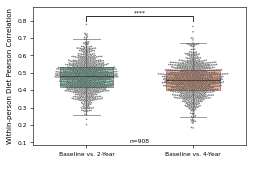

In [195]:
# Generate the plot
fig, ax = plot_paired_correlation_boxplot(
    combined_df_binary,
    reg_code_level_name="RegistrationCode",
    research_stage_level_name="research_stage",
    visit_labels=('baseline_measured', '02_visit_measured', '04_visit_measured'),
    min_corr_periods=5,
    dataset_name="Longitudinal",
    correlation_method='pearson'
)

if fig:
    plt.show()


Logging validation

<Figure size 1200x900 with 0 Axes>

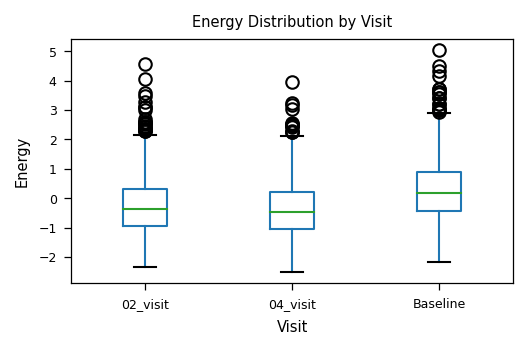

In [155]:
energy_df = pd.DataFrame({
    'Baseline': measured_baseline['Energy'],
    '02_visit': measured_02_visit['Energy'],
    '04_visit': measured_04_visit['Energy']
})

# Melt the DataFrame for easier plotting
energy_melted = energy_df.melt(var_name='Visit', value_name='Energy')

# Create boxplot
plt.figure(figsize=(8, 6))
energy_melted.boxplot(by='Visit', column='Energy', grid=False)
plt.title('Energy Distribution by Visit')
plt.suptitle('')
plt.xlabel('Visit')
plt.ylabel('Energy')
plt.tight_layout()
plt.show()

Prevalence

In [156]:
results_df = pd.read_csv(home_path + f"results/longitudinal/{SUBSET}/longitudinal_analysis_2_years.csv", index_col=0)
results_df

,Pearson Correlation,Pearson Pval,Pearson Pval_adj,Spearman Correlation,Spearman Pval,Spearman Pval_adj,Pearson_Pval_adj_training_corr_order,Spearman_Pval_adj_training_corr_order,species,test_prevalence_baseline,test_prevalence_visit,train_prevalence_baseline,significant,training_set_scores
fBin__541_gBin__2135_sBin__3290,0.094498,1.720414e-04,3.087445e-03,0.082562,1.035860e-03,1.228234e-02,1.720414e-04,1.035860e-03,Lawsonibacter asaccharolyticus,1334,1376,6966,1,0.426409
fBin__187_gBin__748_sBin__1116,0.247424,2.061124e-23,1.368586e-20,0.236196,2.018405e-21,1.340221e-18,2.064233e-23,2.021449e-21,Streptococcus thermophilus,625,639,3154,1,0.423344
fBin__367_gBin__1458_sBin__2166,0.210390,3.166314e-17,1.051216e-14,0.205134,1.956091e-16,6.494222e-14,3.175880e-17,1.962001e-16,UBA11774 sp003507655,1181,1169,5848,1,0.376008
fBin__121_gBin__572_sBin__848,0.143826,9.749140e-09,7.192699e-07,0.132435,1.316025e-07,8.738405e-06,9.793387e-09,1.321998e-07,Bifidobacterium longum,1113,1109,5807,1,0.361910
fBin__367_gBin__1456_sBin__2163,0.089468,3.764198e-04,5.516884e-03,0.085708,6.589922e-04,9.310018e-03,3.787011e-04,6.629861e-04,Pararoseburia lenta,630,660,3007,1,0.324238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fBin__564_gBin__2174_sBin__3339,0.004284,8.650568e-01,9.431818e-01,0.020680,4.119915e-01,6.792478e-01,1.000000e+00,1.000000e+00,Ruminococcus_F champanellensis,93,96,476,0,0.025609
fBin__431_gBin__1689_sBin__2491,0.011267,6.549145e-01,8.140286e-01,0.021351,3.969865e-01,6.673393e-01,1.000000e+00,1.000000e+00,Congzhengia minquanensis,87,88,469,0,0.025561
fBin__601_gBin__2279_sBin__3480,0.032702,1.944446e-01,4.376651e-01,0.008286,7.423877e-01,8.771026e-01,1.000000e+00,1.000000e+00,Ruminococcus sp900540005,191,181,891,0,0.025512
fBin__424_gBin__1678_sBin__2480,-0.011212,6.565021e-01,8.140286e-01,-0.013117,6.028366e-01,8.102904e-01,1.000000e+00,1.000000e+00,Neochristensenella sp003150515,115,120,602,0,0.024920


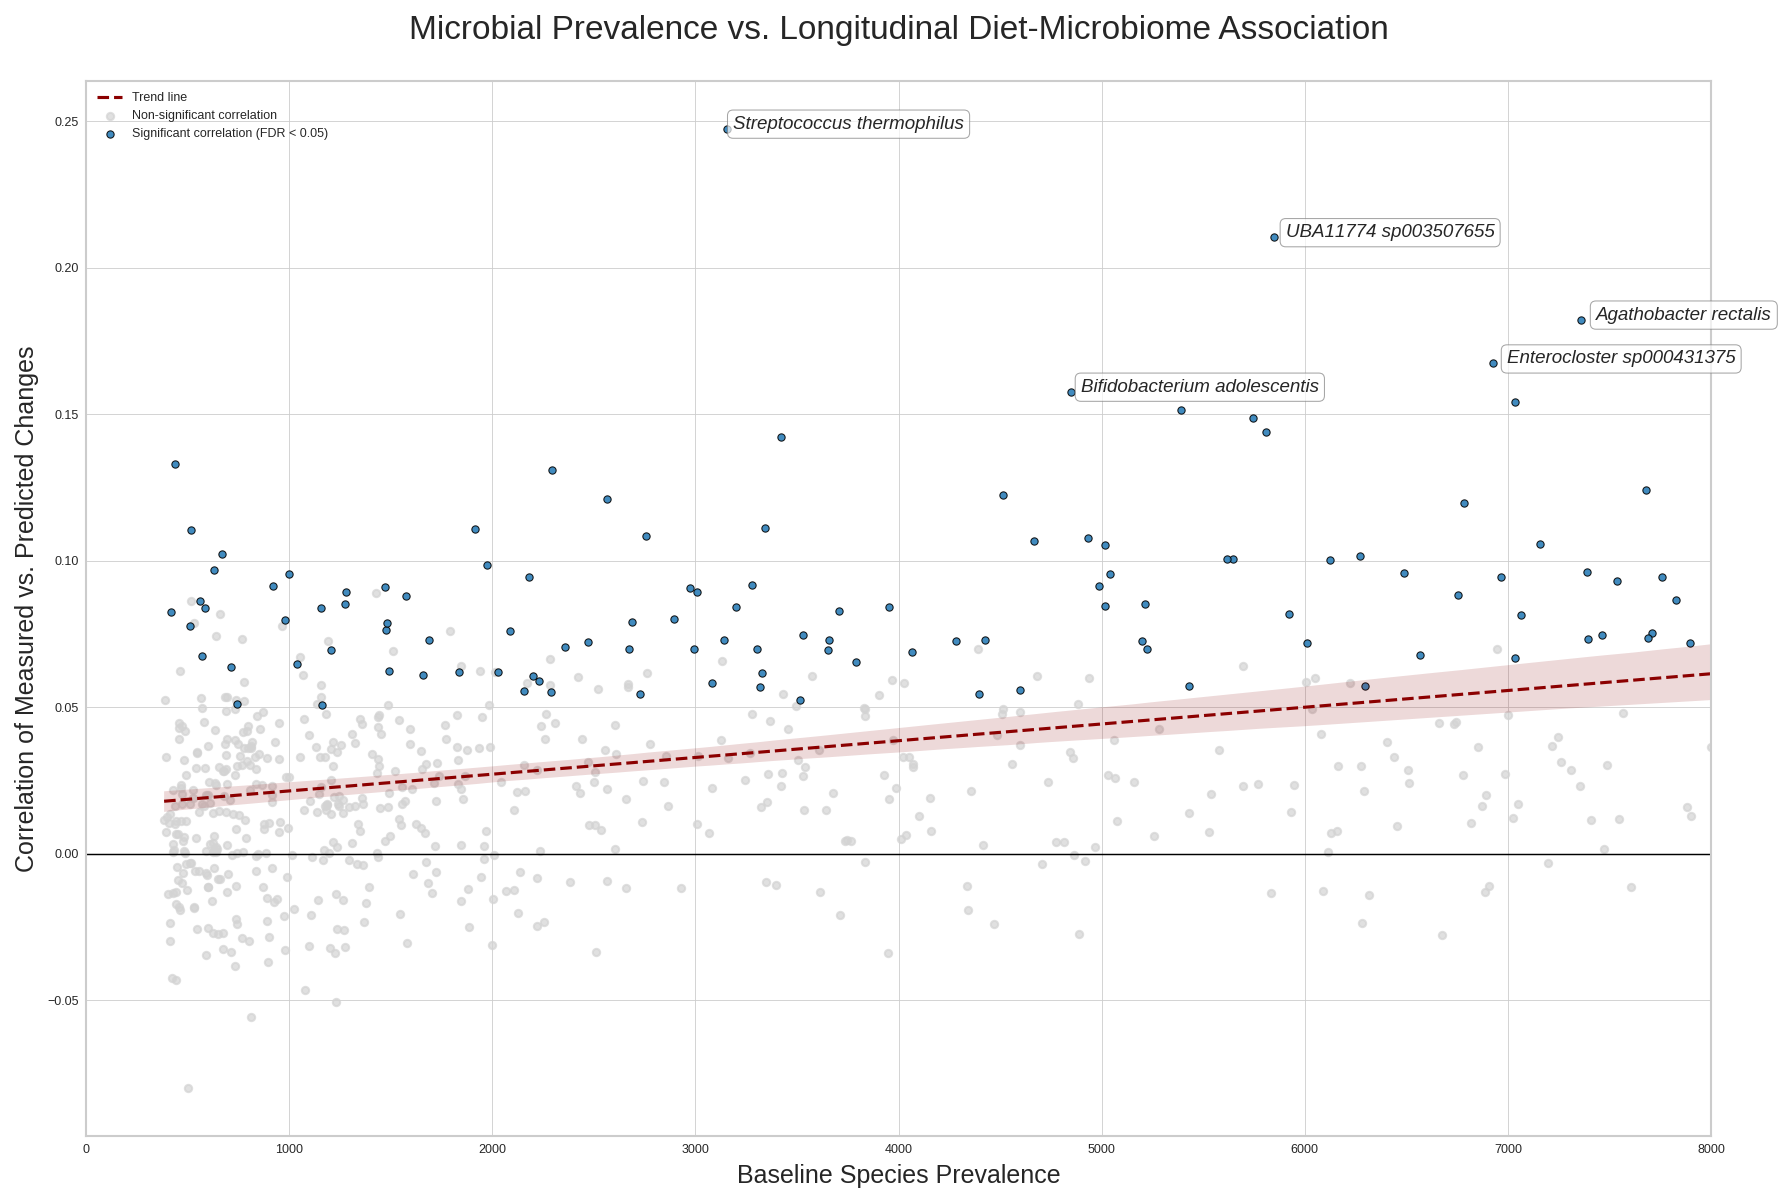

In [157]:
def plot_prevalence_vs_correlation(data, prevalence_col, correlation_col, significance_col, species_col, top_n_to_label=5):
    """
    Generates a scatter plot to visualize the relationship between microbial prevalence
    and the longitudinal correlation between measured and predicted changes.

    Args:
        data (pd.DataFrame): A DataFrame containing the plotting data.
        prevalence_col (str): The name of the column with prevalence data (0 to 1).
        correlation_col (str): The name of the column with Pearson correlation values.
        significance_col (str): The name of the boolean column indicating significance.
        species_col (str): The name of the column with species names for labeling.
        top_n_to_label (int): The number of top-correlated significant species to label.
    """
    # --- Input Validation ---
    required_cols = [prevalence_col, correlation_col, significance_col, species_col]
    if not all(col in data.columns for col in required_cols):
        raise ValueError(f"Dataframe must contain the following columns: {required_cols}")

    # --- Plotting Setup ---
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))

    # --- Create the Scatter Plot ---
    # We'll use two different scatter calls to easily create a legend.
    significant_data = data[data[significance_col] == True]
    nonsignificant_data = data[data[significance_col] == False]

    # Plot non-significant points first (in the background)
    ax.scatter(
        nonsignificant_data[prevalence_col],
        nonsignificant_data[correlation_col],
        color='lightgray',
        alpha=0.7,
        label='Non-significant correlation'
    )

    # Plot significant points on top
    ax.scatter(
        significant_data[prevalence_col],
        significant_data[correlation_col],
        color='#2c7fb8', # A nice blue color
        alpha=0.9,
        edgecolor='black',
        linewidth=0.5,
        label='Significant correlation (FDR < 0.05)'
    )

    # --- Add Trend Line ---
    # Add a regression line for all data points to show the overall trend
    sns.regplot(
        x=prevalence_col,
        y=correlation_col,
        data=data,
        scatter=False, # Don't plot the scatter points again
        color='darkred',
        line_kws={'linestyle':'--', 'linewidth': 1.5},
        ax=ax,
        label='Trend line'
    )


    # --- Annotate Key Species ---
    # Label the most interesting points: the significant species with the highest correlation
    species_to_label = significant_data.nlargest(top_n_to_label, correlation_col)
    for i, row in species_to_label.iterrows():
        ax.text(
            row[prevalence_col] * 1.01, # Position text slightly to the right of the point
            row[correlation_col],
            row[species_col],
            fontsize=9,
            fontstyle='italic',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=0.5, alpha=0.7)
        )


    # --- Final Touches ---
    ax.set_title('Microbial Prevalence vs. Longitudinal Diet-Microbiome Association', fontsize=16, pad=20)
    ax.set_xlabel('Baseline Species Prevalence', fontsize=12)
    ax.set_ylabel('Correlation of Measured vs. Predicted Changes', fontsize=12)
    ax.legend(loc='upper left')

    # Set reasonable limits
    ax.set_xlim(left=0)
    ax.axhline(0, color='black', linestyle='-', linewidth=0.7) # Add a line at y=0

    plt.tight_layout()
    plt.show()


plot_prevalence_vs_correlation(
        data=results_df,
        prevalence_col='train_prevalence_baseline',
        correlation_col='Pearson Correlation',
        significance_col='significant',
        species_col='species',
        top_n_to_label=5 # Label the top 5 significant species
    )

In [158]:
results_df.columns

Index(['Pearson Correlation', 'Pearson Pval', 'Pearson Pval_adj',
       'Spearman Correlation', 'Spearman Pval', 'Spearman Pval_adj',
       'Pearson_Pval_adj_training_corr_order',
       'Spearman_Pval_adj_training_corr_order', 'species',
       'test_prevalence_baseline', 'test_prevalence_visit',
       'train_prevalence_baseline', 'significant', 'training_set_scores'],
      dtype='object')

Plot single species correlation of changes

/usr/wisdom/python3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.


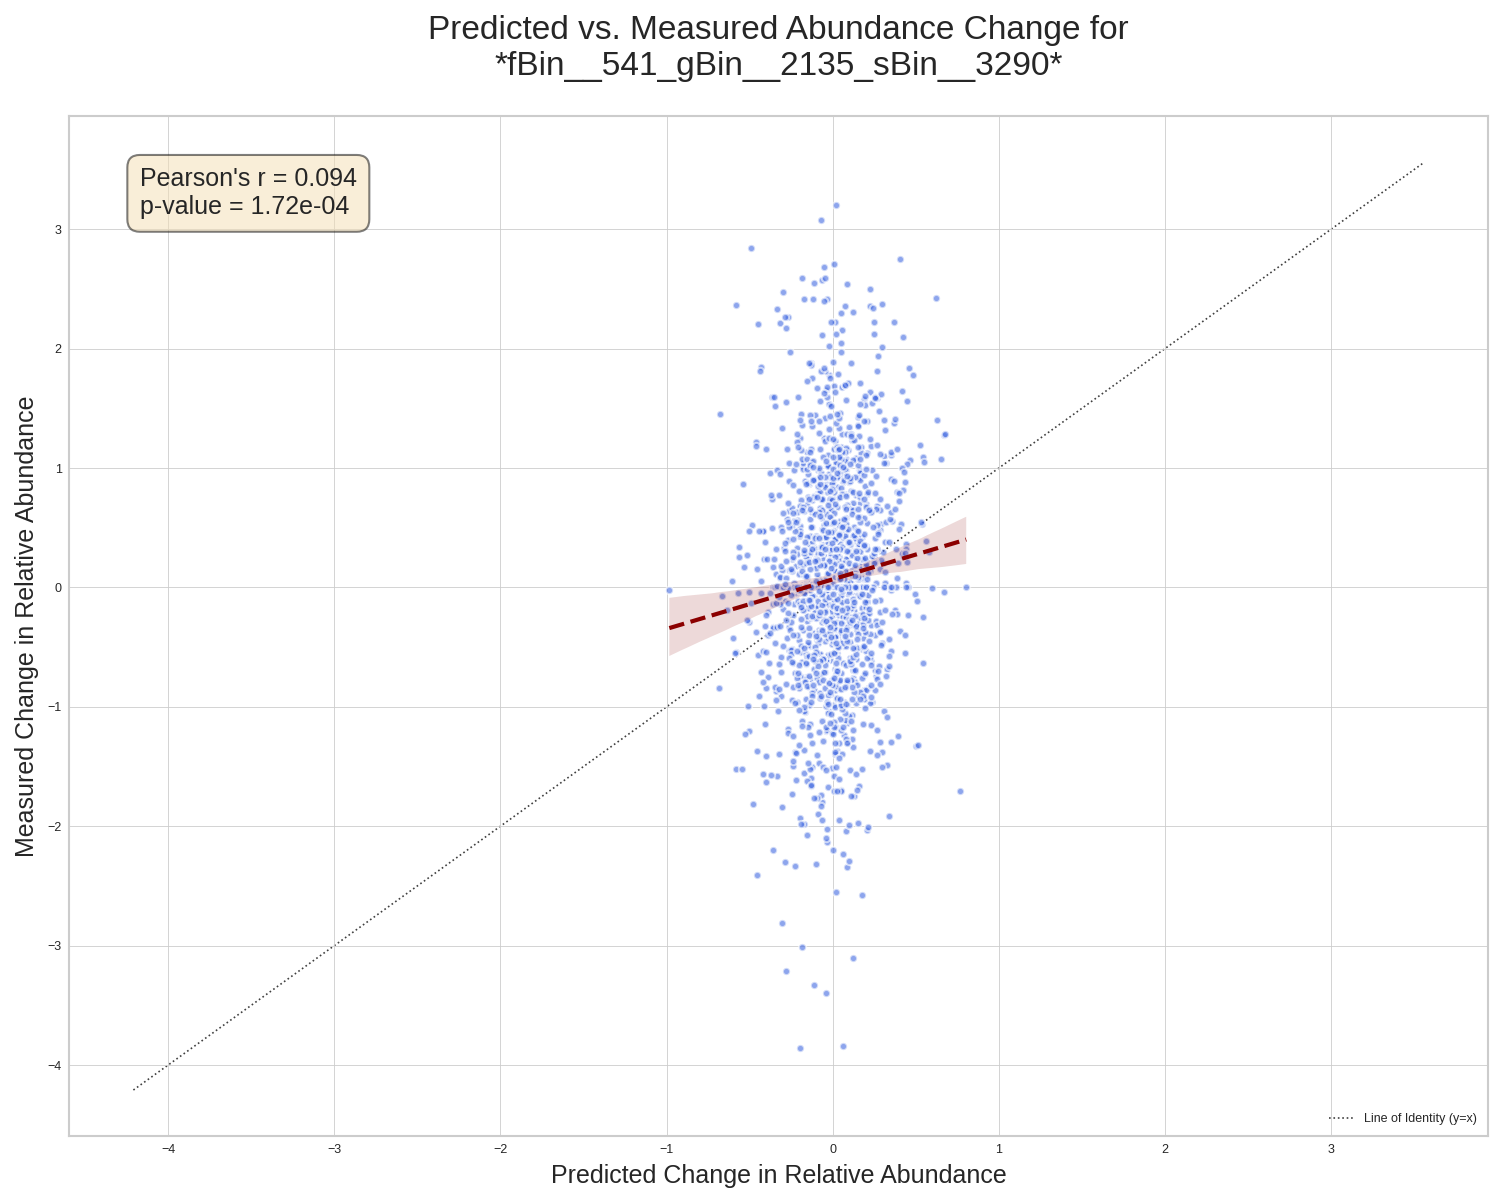

In [159]:
def plot_single_species_correlation(data, predicted_col, measured_col, species_name):
    """
    Generates a scatter plot to visualize the correlation between predicted and
    measured changes for a single microbial species across all participants.

    Args:
        data (pd.DataFrame): A DataFrame where each row is a participant.
        predicted_col (str): The name of the column with predicted abundance changes.
        measured_col (str): The name of the column with measured abundance changes.
        species_name (str): The name of the species for plot titles and labels.
    """
    # --- Input Validation ---
    required_cols = [predicted_col, measured_col]
    if not all(col in data.columns for col in required_cols):
        raise ValueError(f"DataFrame must contain the following columns: {required_cols}")

    # --- Calculate Correlation ---
    # Calculate Pearson correlation and p-value
    corr, p_value = stats.pearsonr(data[predicted_col], data[measured_col])
    
    # --- Plotting Setup ---
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 8))

    # --- Create the Scatter Plot with Regression Line ---
    sns.regplot(
        x=predicted_col,
        y=measured_col,
        data=data,
        ax=ax,
        scatter_kws={'alpha': 0.6, 'color': 'royalblue', 'edgecolor': 'white'},
        line_kws={'color': 'darkred', 'linestyle': '--', 'linewidth': 2}
    )

    # --- Add Identity Line ---
    # This line (y=x) shows where points would lie for a perfect prediction.
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0, linestyle=':', label='Line of Identity (y=x)')


    # --- Final Touches ---
    ax.set_title(f'Predicted vs. Measured Abundance Change for\n*{species_name}*', fontsize=16, pad=20)
    ax.set_xlabel('Predicted Change in Relative Abundance', fontsize=12)
    ax.set_ylabel('Measured Change in Relative Abundance', fontsize=12)
    
    # Add correlation coefficient and p-value to the plot
    ax.text(
        0.05, 0.95,
        f"Pearson's r = {corr:.3f}\np-value = {p_value:.2e}",
        transform=ax.transAxes, # Position relative to the axes
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5)
    )
    
    ax.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

species_to_plot = results_df.index[0]

# --- Prepare the data for the plotting function ---
# The function expects a single DataFrame. We create it by combining the
# relevant columns from your two separate DataFrames.
data_for_plotting = pd.DataFrame({
    'predicted_change': delta_predicted[species_to_plot],
    'measured_change': delta_measured[species_to_plot]
})

# --- Call the plotting function with the prepared data ---
plot_single_species_correlation(
    data=data_for_plotting,
    predicted_col='predicted_change',
    measured_col='measured_change',
    species_name=species_to_plot
)

### Downsampling 2 year visit to check differene in significant correlations of changes

In [160]:
# --- Load 4-year results (already computed earlier) ---
sorted_results_df_4y = pd.read_csv(
    home_path + f"results/longitudinal/{SUBSET}/longitudinal_analysis_4_years.csv",
    index_col=0
)

# --- Downsample 2-year to the same participants used in 4-year deltas ---
# These were already computed earlier in the notebook:
#   delta_measured, delta_predicted, delta_measured_4_years, delta_predicted_4_years
# We do NOT recompute any 4-year quantities.
common_ids = delta_measured_4_years.index.intersection(delta_predicted_4_years.index)
delta_measured_down = delta_measured.loc[common_ids]
delta_predicted_down = delta_predicted.loc[common_ids]

# --- Correlations on 2-year (downsampled) ---
# calculate_correlations was defined earlier - we reuse it
results_df_2y_down = calculate_correlations(delta_measured_down, delta_predicted_down)

# --- Optional species labels (same as earlier logic) ---
if TARGETS == 'abundance':
    results_df_2y_down['species'] = results_df_2y_down.index.map(mb_names['species_new'])

# --- Apply training-order FDR (reuse your existing function) ---
if TARGETS == 'abundance':
    results_df_2y_down = FDR_training_corr_order(lgbm_diet_scores_codes, "Pearson Pval",  results_df_2y_down, "Pearson_Pval_adj_training_corr_order")
    results_df_2y_down = FDR_training_corr_order(lgbm_diet_scores_codes, "Spearman Pval", results_df_2y_down, "Spearman_Pval_adj_training_corr_order")

# --- Prevalence columns for the downsampled comparison only ---
add_prevalence_columns(results_df_2y_down, measured_baseline, measured_02_visit.loc[common_ids], diet_mb_train, significant_targets)

# --- Mark significance (same rule as before) ---
if TARGETS == 'abundance':
    results_df_2y_down['significant'] = (
        (results_df_2y_down['Pearson Correlation'] > 0) &
        (results_df_2y_down['Spearman Correlation'] > 0) &
        (results_df_2y_down['Pearson_Pval_adj_training_corr_order']  < 0.05) &
        (results_df_2y_down['Spearman_Pval_adj_training_corr_order'] < 0.05)
    ).astype(int)

# --- Add training scores and sort to mirror the 4-year file ---
if TARGETS == 'abundance':
    results_df_2y_down['training_set_scores'] = results_df_2y_down.index.map(lgbm_diet_scores_codes)
    sorted_results_df_2y_down = results_df_2y_down.sort_values(by="training_set_scores", ascending=False)
else:
    sorted_results_df_2y_down = results_df_2y_down.copy()

# --- Save 2-year downsampled results ---
sorted_results_df_2y_down.to_csv(
    home_path + f"results/longitudinal/{SUBSET}/longitudinal_analysis_2y_downsampled.csv"
)

# --- Quick check: counts of significant correlations (useful for the paper sentence) ---
n_sig_2y_down = int(sorted_results_df_2y_down.get('significant', pd.Series(0, index=sorted_results_df_2y_down.index)).sum())
n_sig_4y     = int(sorted_results_df_4y.get('significant', pd.Series(0, index=sorted_results_df_4y.index)).sum())
print(f"Significant correlations - 2y downsampled: {n_sig_2y_down}  |  4y: {n_sig_4y}")


Significant correlations - 2y downsampled: 83  |  4y: 92


In [161]:
prints(sorted_results_df_2y_down)
print()
prints(sorted_results_df_4y)

Total significants: 83
Percent of significants: 0.125
Average prevalence of significant microbes in baseline: 764.156626506024
Average prevalence of significant microbes in intervention: 440.4457831325301
Average prevalence of non-significant microbes in baseline: 454.9793459552496
Average prevalence of non-significant microbes in intervention: 264.4543889845095
Average prevalence in 10k: 2503.1927710843374
Average prevalence of non-significants in 10k: 2301.5576592082616

Total significants: 92
Percent of significants: 0.13855421686746988
Average prevalence of significant microbes in baseline: 787.2065217391304
Average prevalence of significant microbes in intervention: 637.75
Average prevalence of non-significant microbes in baseline: 446.40734265734267
Average prevalence of non-significant microbes in intervention: 363.9055944055944
Average prevalence in 10k: 2503.1927710843374
Average prevalence of non-significants in 10k: 2262.1486013986014


In [162]:
from statsmodels.stats.contingency_tables import mcnemar

sig_2y = sorted_results_df_2y_down['significant']
sig_4y = sorted_results_df_4y['significant']

# Build contingency table
a = ((sig_2y == 1) & (sig_4y == 1)).sum()
b = ((sig_2y == 1) & (sig_4y == 0)).sum()
c = ((sig_2y == 0) & (sig_4y == 1)).sum()
d = ((sig_2y == 0) & (sig_4y == 0)).sum()

table = [[a, b],
         [c, d]]

result = mcnemar(table, exact=True)
print(table)
print(f"McNemar p-value: {result.pvalue:.4f}")


[[45, 38], [47, 534]]
McNemar p-value: 0.3857
